# Comparison of different explainers
## CORA - multiclass classification, GCN network

In [ ]:
import torch
from torch.nn import Dropout, ReLU, LogSoftmax
from torch.nn.functional import nll_loss
from torch_geometric.nn import Sequential, GCNConv
from torch_geometric.datasets import Planetoid

torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = Planetoid(root="./data/cora", name="cora")
data = dataset[0].to(device)

model = Sequential("x, edge_index", [
    (GCNConv(dataset.num_features, 16), "x, edge_index -> x"),
    ReLU(inplace=True),
    Dropout(0.5),
    (GCNConv(16, dataset.num_classes), "x, edge_index -> x"),
    LogSoftmax(dim=1)
]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

for _ in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

model.eval()
pred = model(data.x, data.edge_index).argmax(dim=1)
acc_train = (pred[data.train_mask] == data.y[data.train_mask]).sum().item() / data.train_mask.sum().item()
acc_test = (pred[data.test_mask] == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
print(f'Training acc: {acc_train:.2f}, test acc: {acc_test:.2f}')

In [ ]:
from torch_geometric.explain import Explainer, GNNExplainer, PGExplainer, GraphMaskExplainer, CaptumExplainer, metric
from fidelity import fidelity
import numpy as np
import copy
import json

# Gather explanations for random 50 nodes
n_idxs = 50
n_runs = 5
nodes_idxs = torch.randperm(data.num_nodes)[:n_idxs]
topk = [5, 10, 15, 20, 50, 100]

explainer_names = ['GNNExplainer', 'PGExplainer', 'GraphMaskExplainer', 'Saliency', 'InputXGradient']
metric_names = ['Fidelity+', 'Fidelity-', 'Characterization score', 'Unfaithfulness']
results = []
e_model = model

for _ in range(n_runs):
    run_results = {e: {m: [] for m in metric_names } for e in explainer_names}
    for i in range(len(topk)):

        topk_val = topk[i]
        explained_model = copy.deepcopy(e_model)
        fid = {'+': np.zeros(n_idxs), '-': np.zeros(n_idxs)}
        fls = np.zeros(n_idxs)

        # GNNExplainer
        gnn_exp = Explainer(
            model=explained_model,
            algorithm=GNNExplainer(epochs=200).to(device),
            explanation_type='phenomenon',
            edge_mask_type='object',
            model_config=dict(
                mode='multiclass_classification',
                task_level='node',
                return_type='log_probs',
            ),
            threshold_config=dict(threshold_type='topk', value=topk_val),
        )

        # PGExplainer
        pg_exp = Explainer(
            model=explained_model,
            algorithm=PGExplainer(epochs=1, lr=0.001).to(device),
            explanation_type='phenomenon',
            edge_mask_type='object',
            model_config=dict(
                mode='multiclass_classification',
                task_level='node',
                return_type='log_probs',
            ),
            threshold_config=dict(threshold_type='topk', value=topk_val),
        )

        for epoch in range(1):
            for index in range(data.num_nodes):
                pg_exp.algorithm.train(epoch, explained_model, data.x, data.edge_index, target=data.y, index=index)

        # GraphMaskExplainer
        gm_exp = Explainer(
            model=explained_model,
            algorithm=GraphMaskExplainer(2, epochs=10).to(device),
            explanation_type='phenomenon',
            edge_mask_type='object',
            model_config=dict(
                mode='multiclass_classification',
                task_level='node',
                return_type='log_probs',
            ),
            threshold_config=dict(threshold_type='topk', value=topk_val),
        )

        # Saliency
        sal_exp = Explainer(
            model=explained_model,
            algorithm=CaptumExplainer('Saliency').to(device),
            explanation_type='phenomenon',
            model_config=dict(
                mode='multiclass_classification',
                task_level='node',
                return_type='log_probs',
            ),
            edge_mask_type='object',
            threshold_config=dict(threshold_type='topk', value=topk_val),
        )

        # Input X Gradient
        ixg_exp = Explainer(
            model=explained_model,
            algorithm=CaptumExplainer('InputXGradient').to(device),
            explanation_type='phenomenon',
            model_config=dict(
                mode='multiclass_classification',
                task_level='node',
                return_type='log_probs',
            ),
            edge_mask_type='object',
            threshold_config=dict(threshold_type='topk', value=topk_val),
        ) 

        # Gradient methods have to be first in the list
        explainers = { 'Saliency': sal_exp, 'InputXGradient': ixg_exp, 'GNNExplainer': gnn_exp, 'PGExplainer': pg_exp, 'GraphMaskExplainer': gm_exp }
        for name, explainer in explainers.items():
            for j in range(n_idxs):
                node_index = nodes_idxs[j].item()
                explanation = explainer(data.x, data.edge_index, index=node_index, target=data.y)
                fid['+'][j], fid['-'][j] = fidelity(explainer, explanation)
                fls[j] = metric.unfaithfulness(explainer, explanation)

            run_results[name]['Fidelity+'].append(fid['+'].mean())
            run_results[name]['Fidelity-'].append(fid['-'].mean())
            # Replace 0 with 0.001 in fidelity+ to avoid division by zero
            fid['+'][fid['+'] == 0] = 0.001
            # Replace 1 with 0.999 in fidelity- to avoid division by zero
            fid['-'][fid['-'] == 1] = 0.999
            run_results[name]['Characterization score'].append(metric.characterization_score(fid['+'].mean(), fid['-'].mean(), pos_weight=0.5, neg_weight=0.5))
            run_results[name]['Unfaithfulness'].append(fls.mean())
    results.append(run_results)

agg_results = {e: {m: [0] * len(topk) for m in metric_names } for e in explainer_names}
for r in results:
    for e in explainer_names:
        for m in metric_names:
            for i in range(len(topk)):
                agg_results[e][m][i] += r[e][m][i] / n_runs

json.dump(agg_results, open('./CORA_gcn_results.json', 'w'))

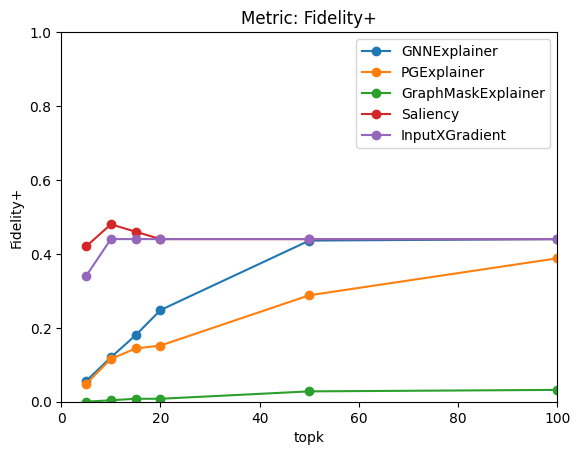

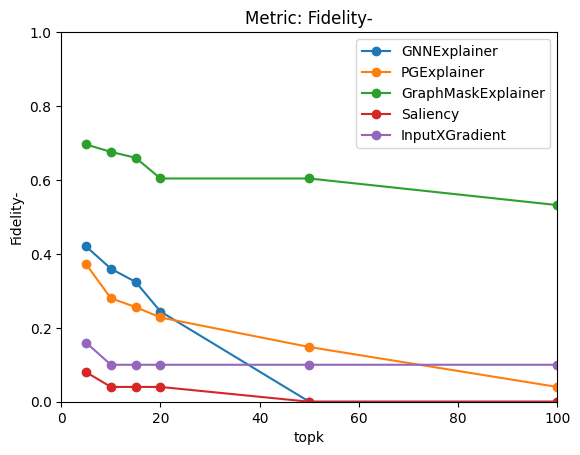

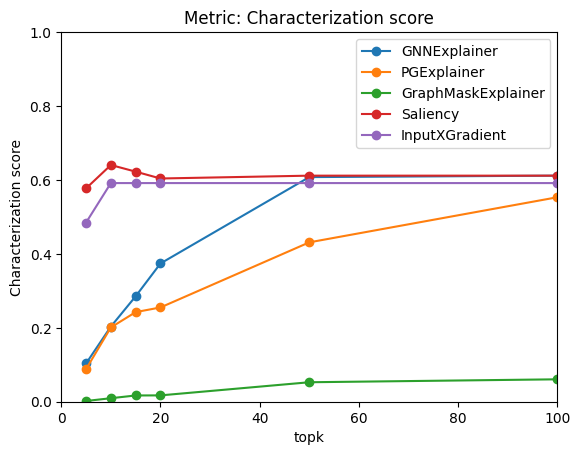

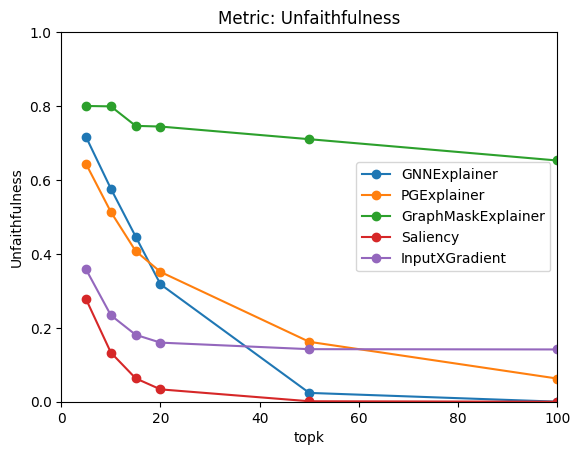

In [3]:
import matplotlib.pyplot as plt

agg_results = json.load(open('./CORA_gcn_results.json', 'r'))

for m in metric_names:
    plt.figure()
    for e in explainer_names:
        plt.plot(topk, agg_results[e][m], marker='o', label=e)
    if m != 'Fidelity AUC':
        plt.ylim(0, 1)
    plt.xlim(0, 100)
    plt.ylabel(m)
    plt.xlabel('topk')
    plt.legend()
    plt.title(f'Metric: {m}')
    plt.show()


## SuperPixel MNIST - graph classification, GCN network

In [10]:
import torch
from torch.nn import ReLU, Linear, Tanh, LogSoftmax
from torch.nn.functional import cross_entropy
from torch_geometric.nn import Sequential, GCNConv, global_mean_pool, BatchNorm
from torch_geometric.datasets import MNISTSuperpixels
from torch_geometric.loader import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = MNISTSuperpixels(root='./data/mnistsuperpixel', train=True)
test_dataset = MNISTSuperpixels(root='./data/mnistsuperpixel', train=False)

BATCH_SIZE = 128
TRAIN_SIZE = 256

train_idx = torch.randperm(len(train_dataset))[:TRAIN_SIZE]

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

hidden_channels = 146

model = Sequential("x, edge_index, batch", [
    (Linear(train_dataset.num_features, hidden_channels), "x -> x"),
    (GCNConv(hidden_channels, hidden_channels, add_self_loops=False), "x, edge_index -> x"),
    (BatchNorm(hidden_channels), "x -> x"),
    ReLU(inplace=True),
    (GCNConv(hidden_channels, hidden_channels, add_self_loops=False), "x, edge_index -> x"),
    (BatchNorm(hidden_channels), "x -> x"),
    ReLU(inplace=True),
    (GCNConv(hidden_channels, hidden_channels, add_self_loops=False), "x, edge_index -> x"),
    (BatchNorm(hidden_channels), "x -> x"),
    ReLU(inplace=True),
    (GCNConv(hidden_channels, hidden_channels, add_self_loops=False), "x, edge_index -> x"),
    (BatchNorm(hidden_channels), "x -> x"),
    ReLU(inplace=True),
    (global_mean_pool, "x, batch -> x"),
    (Linear(hidden_channels, train_dataset.num_classes), "x -> x"),
]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, min_lr=1e-5)

def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())
    return correct / len(loader.dataset)

for i in range(1, 201):
    model.train()
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()
    train_acc = test(train_loader)
    scheduler.step(train_acc)
    if i % 10 == 0:
        print(f'Epoch: {i:03d}, Train: {train_acc:.4f}')
torch.save(model.state_dict(), './mnist_superpixels.pt')

In [19]:
state_dict = torch.load('./mnist_superpixels.pt')
model = Sequential("x, edge_index", [
    (Linear(train_dataset.num_features, hidden_channels), "x -> x"),
    (GCNConv(hidden_channels, hidden_channels, add_self_loops=False), "x, edge_index -> x"),
    (BatchNorm(hidden_channels), "x -> x"),
    ReLU(inplace=True),
    (GCNConv(hidden_channels, hidden_channels, add_self_loops=False), "x, edge_index -> x"),
    (BatchNorm(hidden_channels), "x -> x"),
    ReLU(inplace=True),
    (GCNConv(hidden_channels, hidden_channels, add_self_loops=False), "x, edge_index -> x"),
    (BatchNorm(hidden_channels), "x -> x"),
    ReLU(inplace=True),
    (GCNConv(hidden_channels, hidden_channels, add_self_loops=False), "x, edge_index -> x"),
    (BatchNorm(hidden_channels), "x -> x"),
    ReLU(inplace=True),
    (global_mean_pool, "x, None -> x"),
    (Linear(hidden_channels, train_dataset.num_classes), "x -> x"),
]).to(device)

model.load_state_dict(state_dict, strict=True)
model.eval()

In [ ]:
from torch_geometric.explain import Explainer, GNNExplainer, PGExplainer, CaptumExplainer, metric
from fidelity import fidelity
import numpy as np
import copy
import json

# Gather explanations for random 50 nodes
# Explanation - edge mask
n_idxs = 50
n_runs = 5
graph_idxs = torch.randperm(len(test_dataset))[:n_idxs]
topk = [5, 10, 15, 20, 50, 100]

explainer_names = ['GNNExplainer', 'PGExplainer', 'Saliency', 'InputXGradient']
metric_names = ['Fidelity+', 'Fidelity-', 'Characterization score', 'Unfaithfulness']
results = []
e_model = model

for _ in range(n_runs):
    run_results = {e: {m: [] for m in metric_names } for e in explainer_names}
    for i in range(len(topk)):

        topk_val = topk[i]
        explained_model = copy.deepcopy(e_model)
        fid = {'+': np.zeros(n_idxs), '-': np.zeros(n_idxs)}
        fls = np.zeros(n_idxs)

        # GNNExplainer
        gnn_exp = Explainer(
            model=explained_model,
            algorithm=GNNExplainer(epochs=200).to(device),
            explanation_type='phenomenon',
            edge_mask_type='object',
            model_config=dict(
                mode='multiclass_classification',
                task_level='graph',
                return_type='log_probs',
            ),
            threshold_config=dict(threshold_type='topk', value=topk_val),
        )

        # PGExplainer
        pg_exp = Explainer(
            model=explained_model,
            algorithm=PGExplainer(epochs=1, lr=0.001).to(device),
            explanation_type='phenomenon',
            edge_mask_type='object',
            model_config=dict(
                mode='multiclass_classification',
                task_level='graph',
                return_type='log_probs',
            ),
            threshold_config=dict(threshold_type='topk', value=topk_val),
        )

        for epoch in range(1):
            for index in train_idx:
                data = train_dataset[index].to(device)
                pg_exp.algorithm.train(epoch, explained_model, data.x, data.edge_index, target=data.y)

        # GraphMaskExplainer is not compatible with this model

        # Saliency
        sal_exp = Explainer(
            model=explained_model,
            algorithm=CaptumExplainer('Saliency').to(device),
            explanation_type='phenomenon',
            model_config=dict(
                mode='multiclass_classification',
                task_level='graph',
                return_type='log_probs',
            ),
            edge_mask_type='object',
            threshold_config=dict(threshold_type='topk', value=topk_val),
        )

        # Input X Gradient
        ixg_exp = Explainer(
            model=explained_model,
            algorithm=CaptumExplainer('InputXGradient').to(device),
            explanation_type='phenomenon',
            model_config=dict(
                mode='multiclass_classification',
                task_level='graph',
                return_type='log_probs',
            ),
            edge_mask_type='object',
            threshold_config=dict(threshold_type='topk', value=topk_val),
        )

        # Gradient methods have to be first in the list
        explainers = { 'Saliency': sal_exp, 'InputXGradient': ixg_exp, 'GNNExplainer': gnn_exp, 'PGExplainer': pg_exp}
        for name, explainer in explainers.items():
            for j in range(n_idxs):
                graph_index = graph_idxs[j].item()
                data = test_dataset[graph_index].to(device)
                explanation = explainer(data.x, data.edge_index, target=data.y)
                fid['+'][j], fid['-'][j] = fidelity(explainer, explanation)
                fls[j] = metric.unfaithfulness(explainer, explanation)
            run_results[name]['Fidelity+'].append(fid['+'].mean())
            run_results[name]['Fidelity-'].append(fid['-'].mean())
            # Replace 0 with 0.001 in fidelity+ to avoid division by zero
            fid['+'][fid['+'] == 0] = 0.001
            # Replace 1 with 0.999 in fidelity- to avoid division by zero
            fid['-'][fid['-'] == 1] = 0.999
            run_results[name]['Characterization score'].append(metric.characterization_score(fid['+'].mean(), fid['-'].mean(), pos_weight=0.5, neg_weight=0.5))
            run_results[name]['Unfaithfulness'].append(fls.mean())
    results.append(run_results)

agg_results = {e: {m: [0] * len(topk) for m in metric_names } for e in explainer_names}
for r in results:
    for e in explainer_names:
        for m in metric_names:
            for i in range(len(topk)):
                agg_results[e][m][i] += r[e][m][i] / n_runs

json.dump(agg_results, open('./MNISTSuperPixel_gcn_results.json', 'w'))

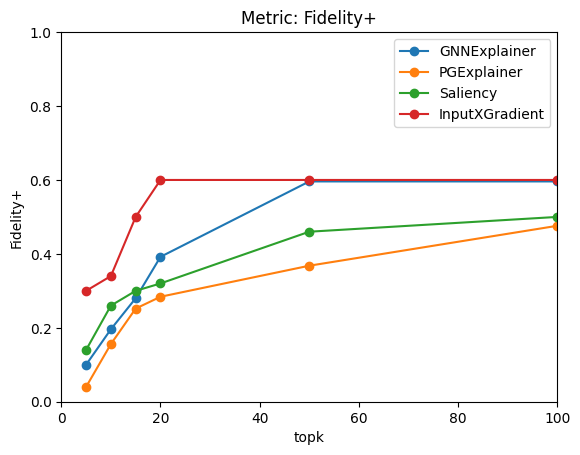

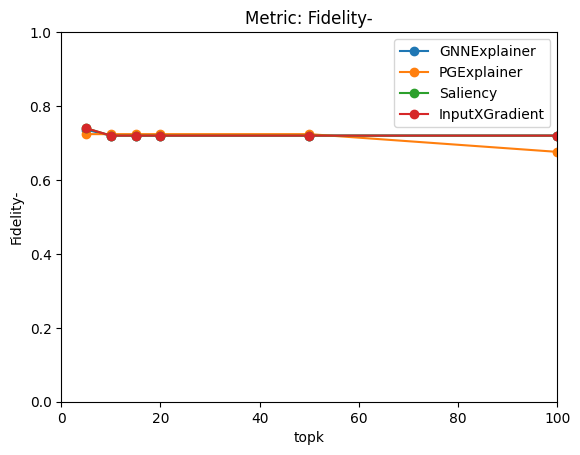

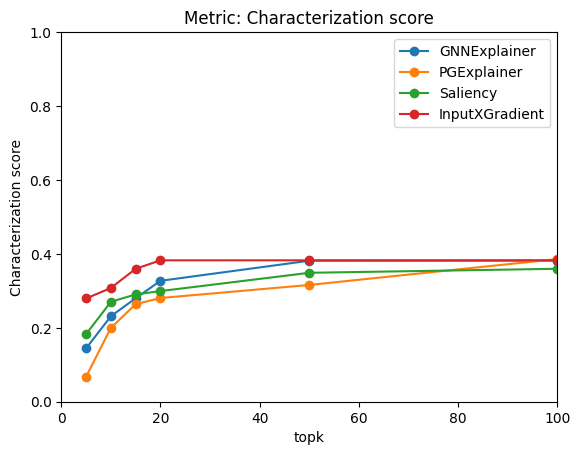

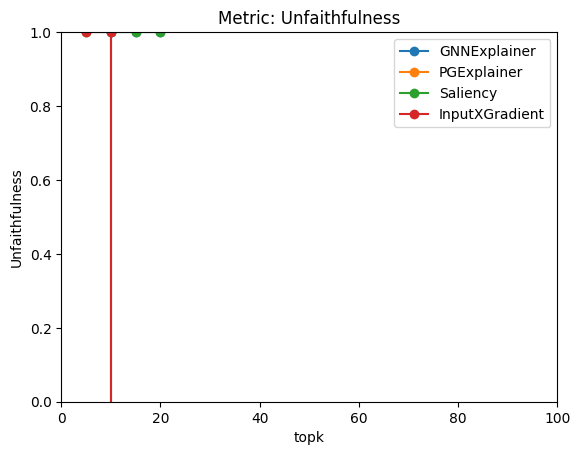

In [47]:
import matplotlib.pyplot as plt

agg_results = json.load(open('./MNISTSuperPixel_gcn_results.json', 'r'))

for m in metric_names:
    plt.figure()
    for e in explainer_names:
        plt.plot(topk, agg_results[e][m], marker='o', label=e)
    if m != 'Fidelity AUC':
        plt.ylim(0, 1)
    plt.xlim(0, 100)
    plt.ylabel(m)
    plt.xlabel('topk')
    plt.legend()
    plt.title(f'Metric: {m}')
    plt.show()

In [49]:
from torch_geometric.explain import Explainer, GNNExplainer, PGExplainer, CaptumExplainer, metric
from fidelity import fidelity
import numpy as np
import copy
import json

# Gather explanations for random 50 nodes
# Explanation - node mask
n_idxs = 50
n_runs = 5
graph_idxs = torch.randperm(len(test_dataset))[:n_idxs]
topk = [5, 10, 15, 20, 50, 100]

explainer_names = ['GNNExplainer', 'Saliency', 'InputXGradient']
metric_names = ['Fidelity+', 'Fidelity-', 'Characterization score', 'Unfaithfulness']
results = []
e_model = model

for _ in range(n_runs):
    run_results = {e: {m: [] for m in metric_names } for e in explainer_names}
    for i in range(len(topk)):

        topk_val = topk[i]
        explained_model = copy.deepcopy(e_model)
        fid = {'+': np.zeros(n_idxs), '-': np.zeros(n_idxs)}
        fls = np.zeros(n_idxs)

        # GNNExplainer
        gnn_exp = Explainer(
            model=explained_model,
            algorithm=GNNExplainer(epochs=200).to(device),
            explanation_type='phenomenon',
            node_mask_type='object',
            model_config=dict(
                mode='multiclass_classification',
                task_level='graph',
                return_type='log_probs',
            ),
            threshold_config=dict(threshold_type='topk', value=topk_val),
        )

        # PGExplainer does not support node mask
        # GraphMaskExplainer is not compatible with this model

        # Saliency
        sal_exp = Explainer(
            model=explained_model,
            algorithm=CaptumExplainer('Saliency').to(device),
            explanation_type='phenomenon',
            model_config=dict(
                mode='multiclass_classification',
                task_level='graph',
                return_type='log_probs',
            ),
            node_mask_type='attributes',
            threshold_config=dict(threshold_type='topk', value=topk_val),
        )

        # Input X Gradient
        ixg_exp = Explainer(
            model=explained_model,
            algorithm=CaptumExplainer('InputXGradient').to(device),
            explanation_type='phenomenon',
            model_config=dict(
                mode='multiclass_classification',
                task_level='graph',
                return_type='log_probs',
            ),
            node_mask_type='attributes',
            threshold_config=dict(threshold_type='topk', value=topk_val),
        )

        # Gradient methods have to be first in the list
        explainers = { 'Saliency': sal_exp, 'InputXGradient': ixg_exp, 'GNNExplainer': gnn_exp }
        for name, explainer in explainers.items():
            for j in range(n_idxs):
                graph_index = graph_idxs[j].item()
                data = test_dataset[graph_index].to(device)
                explanation = explainer(data.x, data.edge_index, target=data.y)
                fid['+'][j], fid['-'][j] = fidelity(explainer, explanation)
                fls[j] = metric.unfaithfulness(explainer, explanation)
            run_results[name]['Fidelity+'].append(fid['+'].mean())
            run_results[name]['Fidelity-'].append(fid['-'].mean())
            # Replace 0 with 0.001 in fidelity+ to avoid division by zero
            fid['+'][fid['+'] == 0] = 0.001
            # Replace 1 with 0.999 in fidelity- to avoid division by zero
            fid['-'][fid['-'] == 1] = 0.999
            run_results[name]['Characterization score'].append(metric.characterization_score(fid['+'].mean(), fid['-'].mean(), pos_weight=0.5, neg_weight=0.5))
            run_results[name]['Unfaithfulness'].append(fls.mean())
    results.append(run_results)

agg_results = {e: {m: [0] * len(topk) for m in metric_names } for e in explainer_names}
for r in results:
    for e in explainer_names:
        for m in metric_names:
            for i in range(len(topk)):
                agg_results[e][m][i] += r[e][m][i] / n_runs

json.dump(agg_results, open('./MNISTSuperPixel_gcn_results_node_mask.json', 'w'))

d:\python_venvs\pytorch-2.1.0\Lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


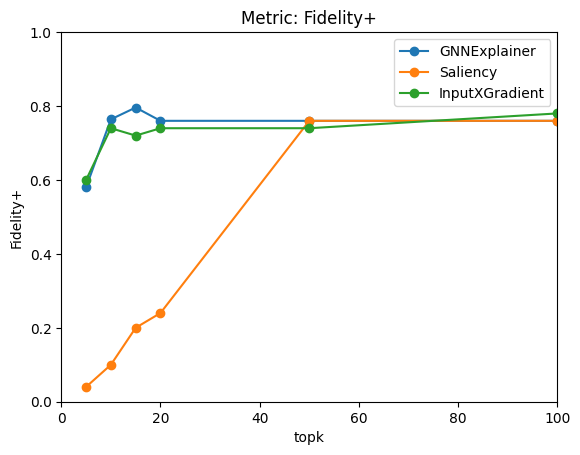

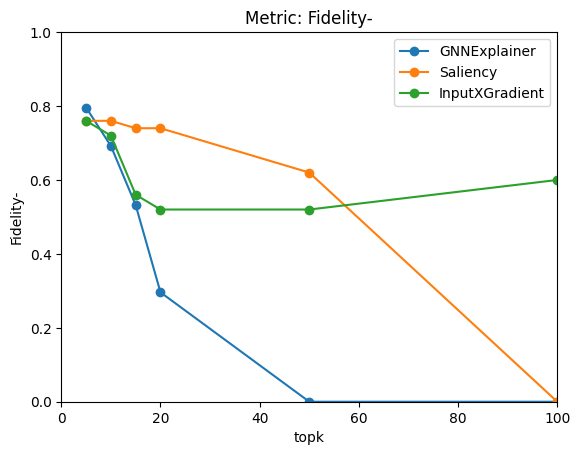

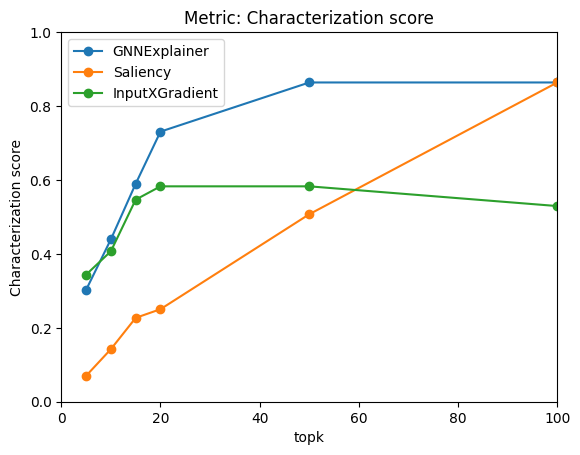

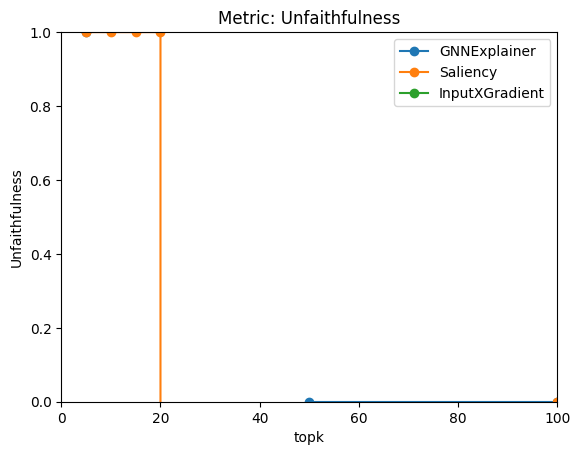

In [50]:
import matplotlib.pyplot as plt

agg_results = json.load(open('./MNISTSuperPixel_gcn_results_node_mask.json', 'r'))

for m in metric_names:
    plt.figure()
    for e in explainer_names:
        plt.plot(topk, agg_results[e][m], marker='o', label=e)
    if m != 'Fidelity AUC':
        plt.ylim(0, 1)
    plt.xlim(0, 100)
    plt.ylabel(m)
    plt.xlabel('topk')
    plt.legend()
    plt.title(f'Metric: {m}')
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

agg_results = json.load(open('./MNISTSuperPixel_gcn_results_node_mask.json', 'r'))

for m in metric_names:
    plt.figure()
    for e in explainer_names:
        plt.plot(topk, agg_results[e][m], marker='o', label=e)
    if m != 'Fidelity AUC':
        plt.ylim(0, 1)
    plt.xlim(0, 100)
    plt.ylabel(m)
    plt.xlabel('topk')
    plt.legend()
    plt.title(f'Metric: {m}')
    plt.show()

In [39]:
import numpy as np
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt

# Source: https://github.com/pyg-team/pytorch_geometric/pull/2488
# by Yihang Yin, https://github.com/Somedaywilldo
def visualize(image, data, explanations, cmap):
    plt.figure(figsize=(18, 9))

    # plot the mnist image
    plt.subplot(1, 2, 1)
    plt.title("MNIST")
    np_image = np.array(image)
    plt.imshow(np_image, cmap=cmap)
    plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    # plot the super-pixel graph
    plt.subplot(1, 2, 2)
    x, edge_index = data.x, data.edge_index
    # construct networkx graph
    df = pd.DataFrame({'from': edge_index[0], 'to': edge_index[1]})
    G = nx.from_pandas_edgelist(df, 'from', 'to')    
    # flip over the axis of pos, this is because the default axis direction of networkx is different
    pos = {i: np.array([data.pos[i][0], 27 - data.pos[i][1]]) for i in range(data.num_nodes)}
    idx = list(G.nodes())
    size = []
    color = []
    for i in idx:
        grey = x[i]
        color.append(grey.item())
        size.append(1000 * grey.item())

    ax = plt.gca()
    ax.set_facecolor((cmap(0)))
    nx.draw_networkx_nodes(G, node_size=size, node_color=color, cmap=cmap, pos=pos)
    plt.title("MNIST Superpixel")

    n_cols = len(explanations)
    plt.figure(figsize=(9 * n_cols, 9))
    col = 1
    for explanation in explanations:
        plt.subplot(1, n_cols, col)
        plt.title(explanation['name'])
        ax = plt.gca()
        ax.set_facecolor((cmap(0)))
        nx.draw_networkx_nodes(G, node_size=size, node_color=color, cmap=cmap, pos=pos)
        # draw circles around most important nodes
        ax = plt.gca()
        
        for idx, (x, y) in pos.items():
            if explanation['node_mask'][idx][0] > 0:
                circle = plt.Circle((x, y), radius=1.1, color='red', fill=False, linewidth=1)
                circle.set_zorder(10)
                ax.add_artist(circle)
        col+=1

In [43]:
from torch_geometric.explain import Explainer, GNNExplainer, CaptumExplainer
import copy
import json

indexes = [
    3,  # 0
    2,  # 1
    35, # 2
    30, # 3
    4,  # 4
    15, # 5
    21, # 6
    0,  # 7
    61, # 8
    9,  # 9
]

numbers = test_dataset[indexes]

explained_model = copy.deepcopy(model)
explained_model.eval()
topk_val = 10

# GNNExplainer
gnn_exp = Explainer(
    model=explained_model,
    algorithm=GNNExplainer(epochs=200).to(device),
    explanation_type='phenomenon',
    node_mask_type='attributes',
    model_config=dict(
        mode='multiclass_classification',
        task_level='graph',
        return_type='log_probs',
    ),
    threshold_config=dict(threshold_type='topk', value=topk_val),
)

# PGExplainer does not support node mask

# SHAP
shap_exp = Explainer(
    model=explained_model,
    algorithm=CaptumExplainer('ShapleyValueSampling').to(device),
    explanation_type='phenomenon',
    node_mask_type='attributes',
    model_config=dict(
        mode='multiclass_classification',
        task_level='graph',
        return_type='log_probs',
    ),
    threshold_config=dict(threshold_type='topk', value=topk_val),
)

# Saliency
sal_exp = Explainer(
    model=explained_model,
    algorithm=CaptumExplainer('Saliency').to(device),
    explanation_type='phenomenon',
    node_mask_type='attributes',
    model_config=dict(
        mode='multiclass_classification',
        task_level='graph',
        return_type='log_probs',
    ),
    threshold_config=dict(threshold_type='topk', value=topk_val),
)

# Input X Gradient
ixg_exp = Explainer(
    model=explained_model,
    algorithm=CaptumExplainer('InputXGradient').to(device),
    explanation_type='phenomenon',
    node_mask_type='attributes',
    model_config=dict(
        mode='multiclass_classification',
        task_level='graph',
        return_type='log_probs',
    ),
    threshold_config=dict(threshold_type='topk', value=topk_val),
)

explainers = [ {'name': 'GNNExplainer', 'explainer': gnn_exp}, {'name': 'SHAP', 'explainer': shap_exp}, {'name': 'Saliency', 'explainer': sal_exp}, {'name': 'InputXGradient', 'explainer': ixg_exp} ]
results = []

for data in numbers:
    for explainer in explainers:
        explanation = explainer['explainer'](data.x, data.edge_index, target=data.y)
        results.append({'name': explainer['name'], 'node_mask': explanation.node_mask.cpu().tolist()})


json.dump(results, open('./MNISTSuperPixel_gcn_explanations.json', 'w'))

d:\python_venvs\pytorch-2.1.0\Lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


Class: 0, Prediction: 0
Class: 1, Prediction: 1
Class: 2, Prediction: 2
Class: 3, Prediction: 3
Class: 4, Prediction: 4
Class: 5, Prediction: 5
Class: 6, Prediction: 6
Class: 7, Prediction: 7
Class: 8, Prediction: 8
Class: 9, Prediction: 9


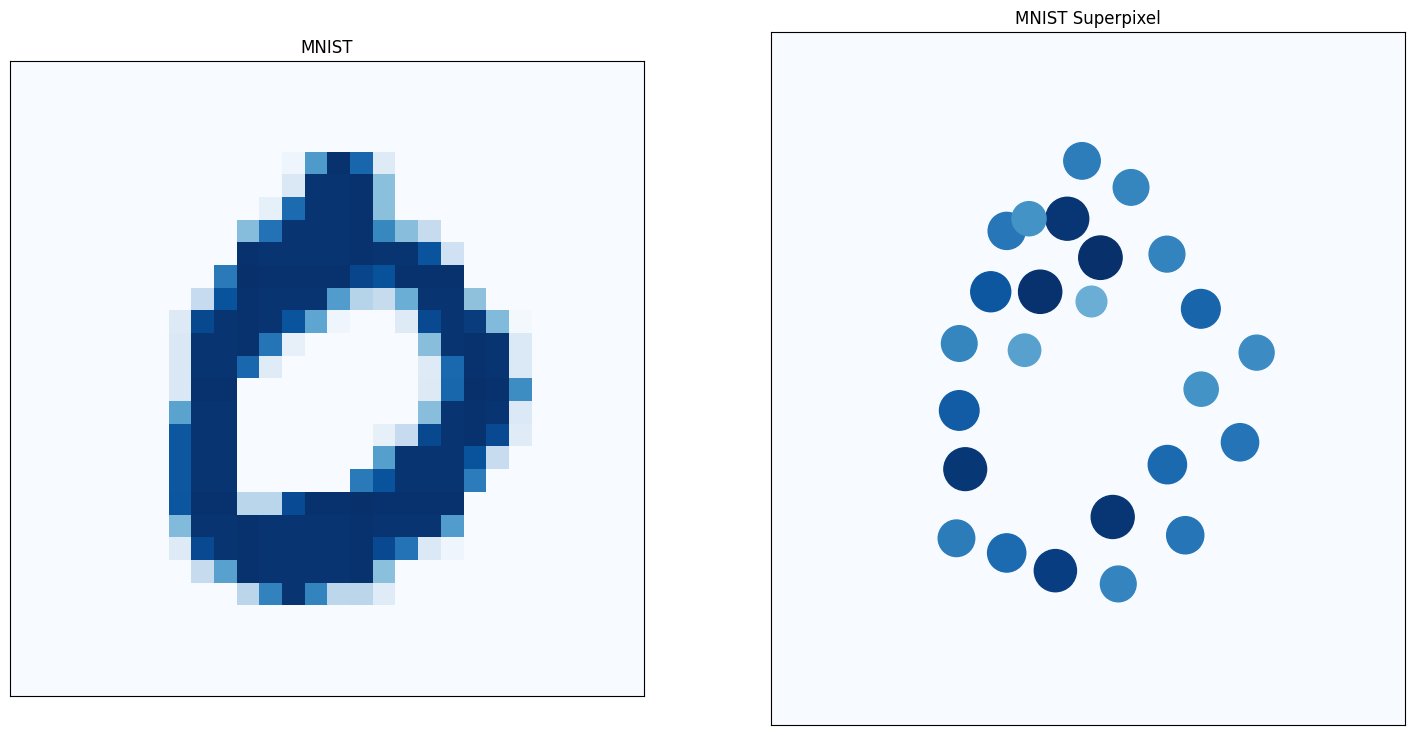

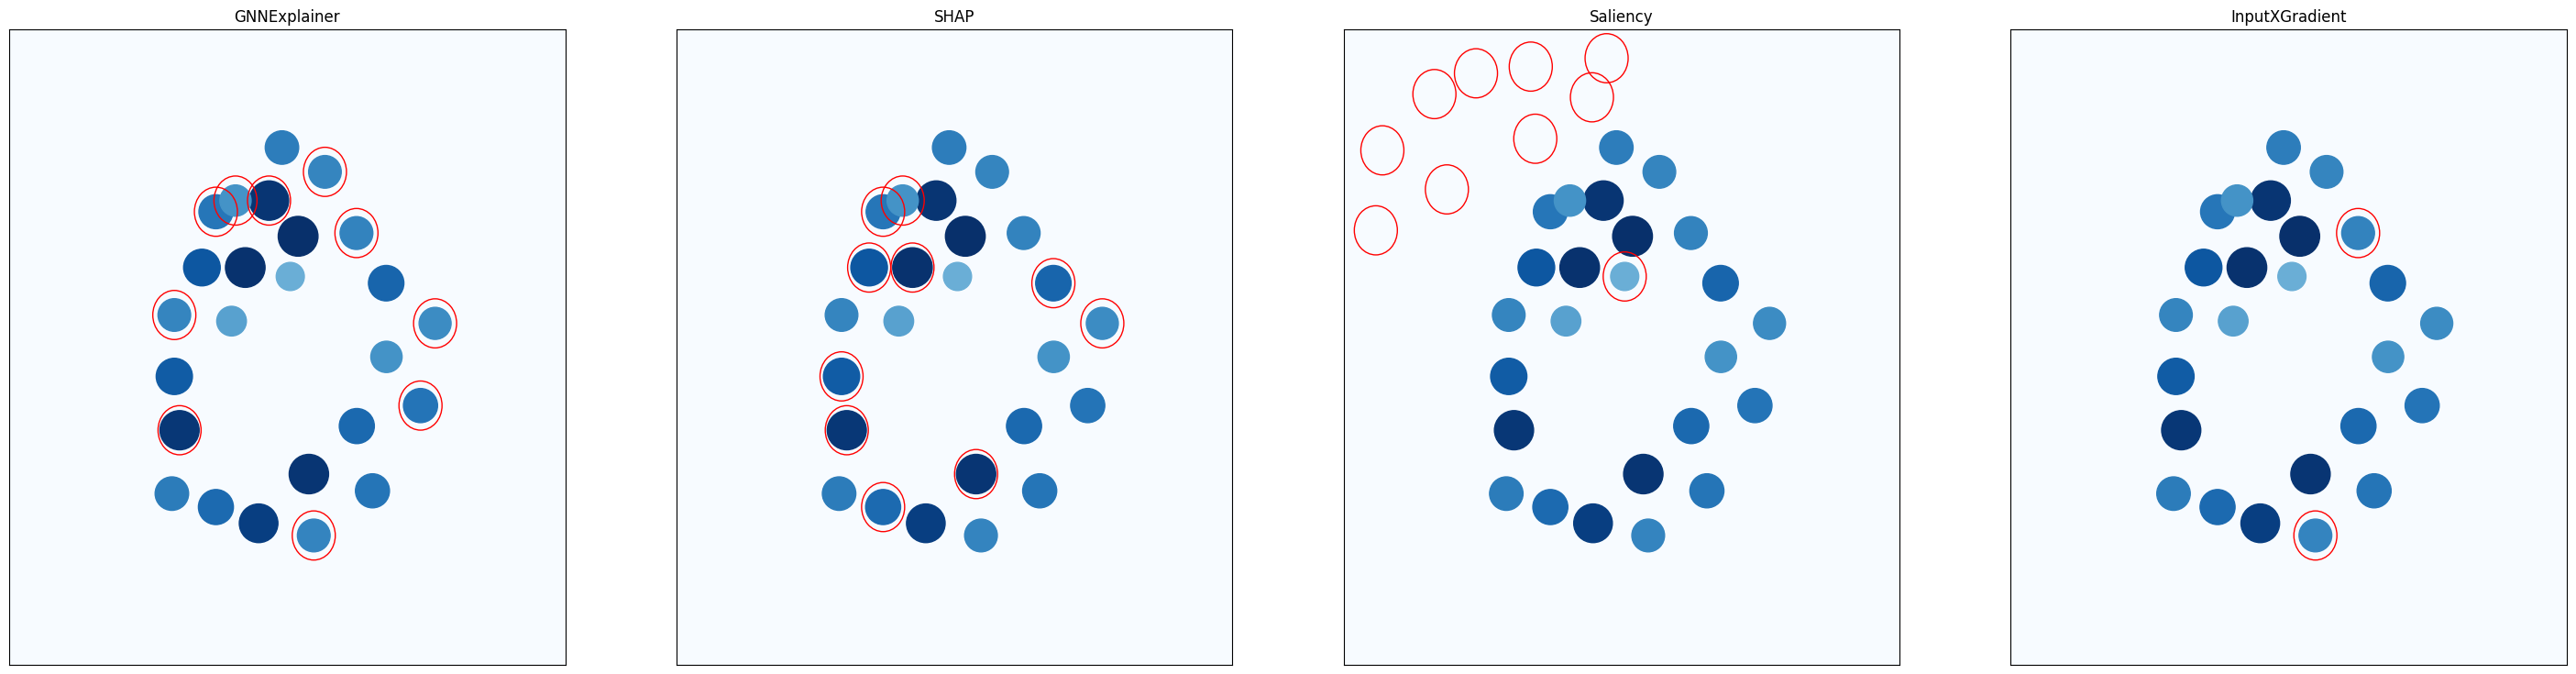

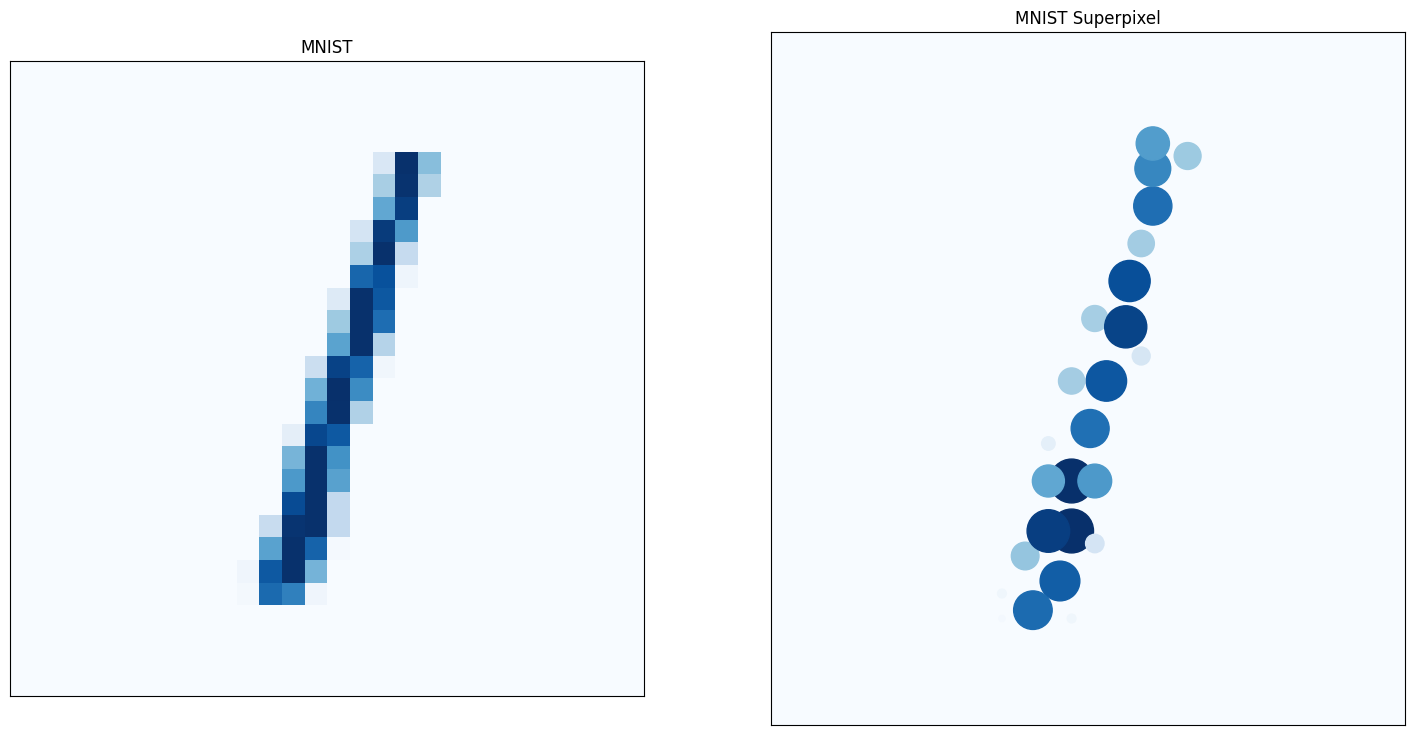

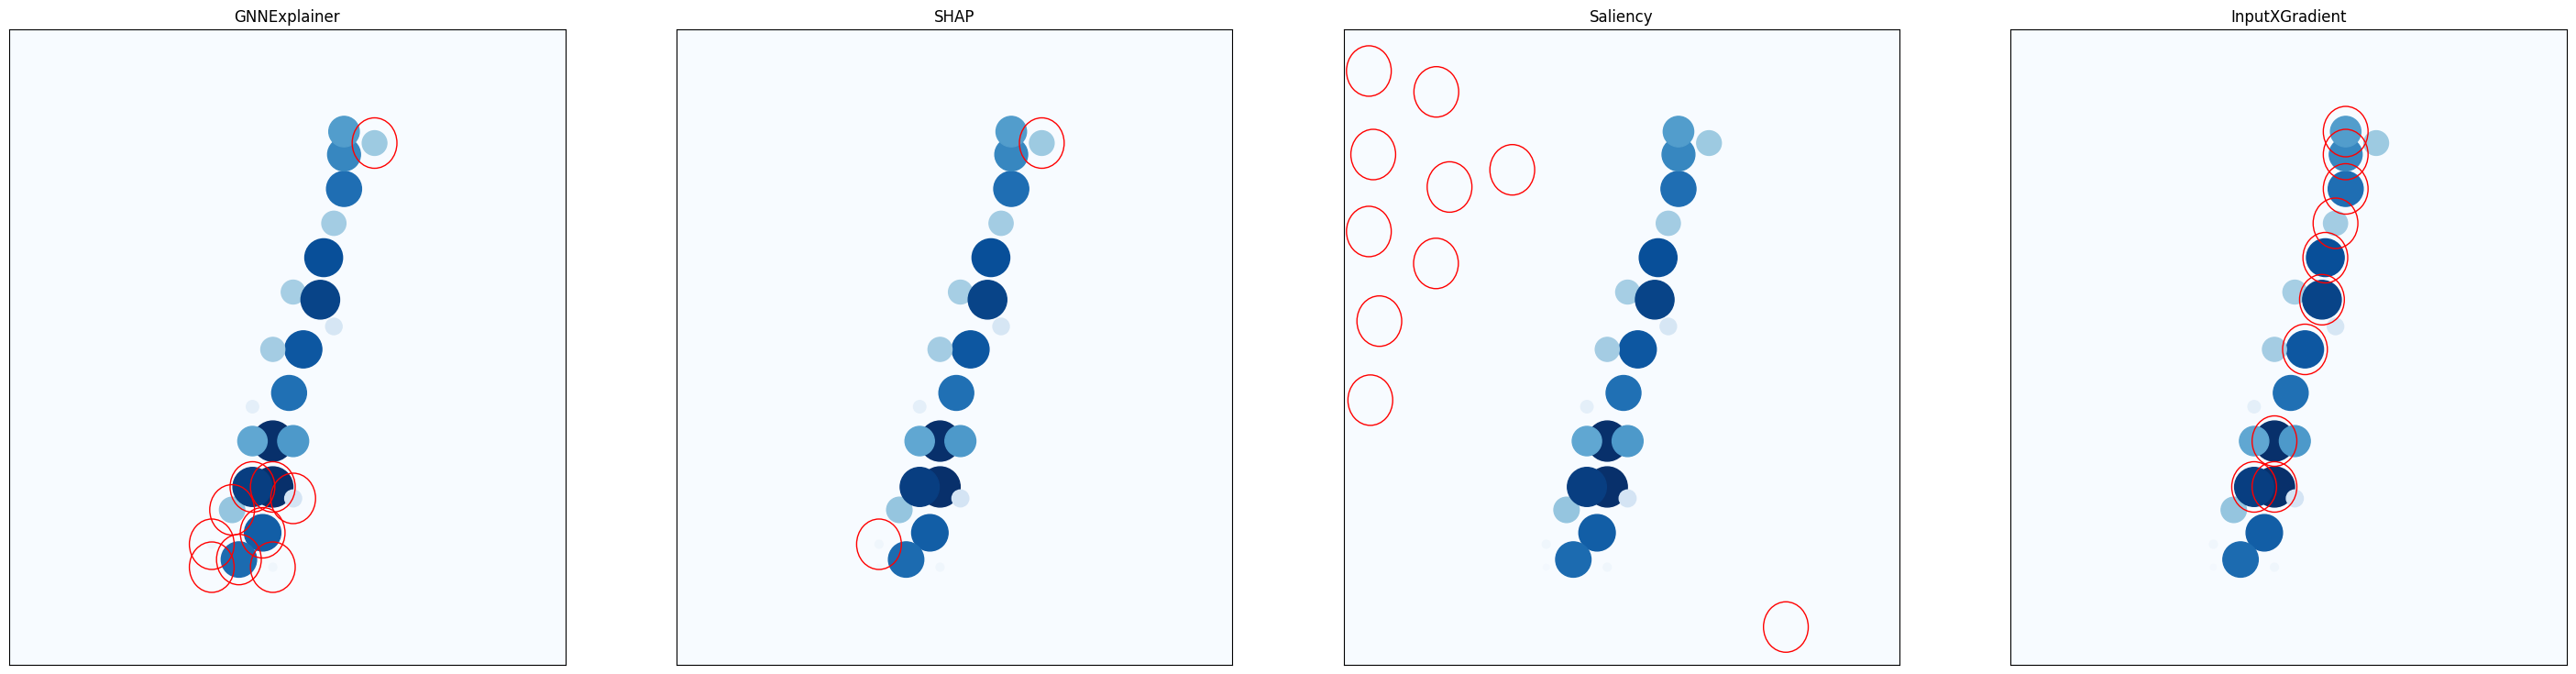

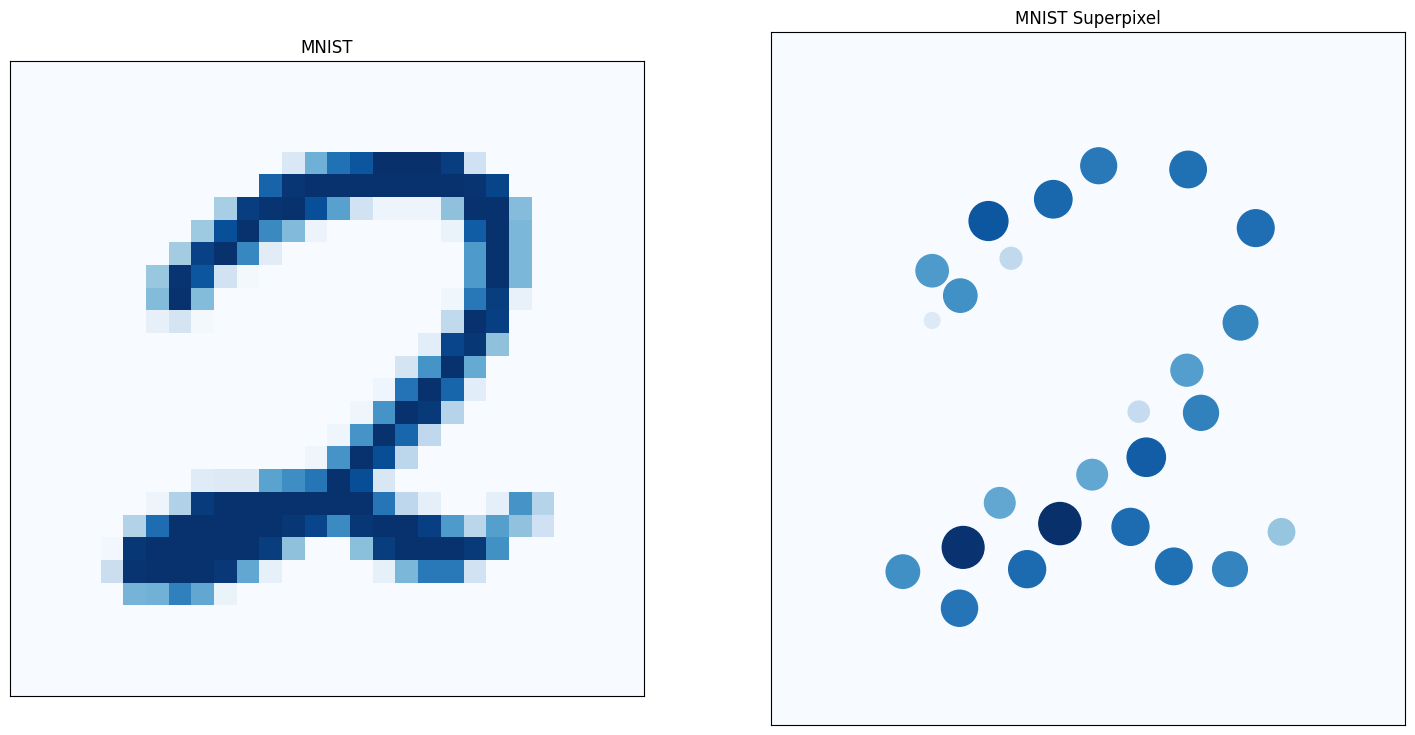

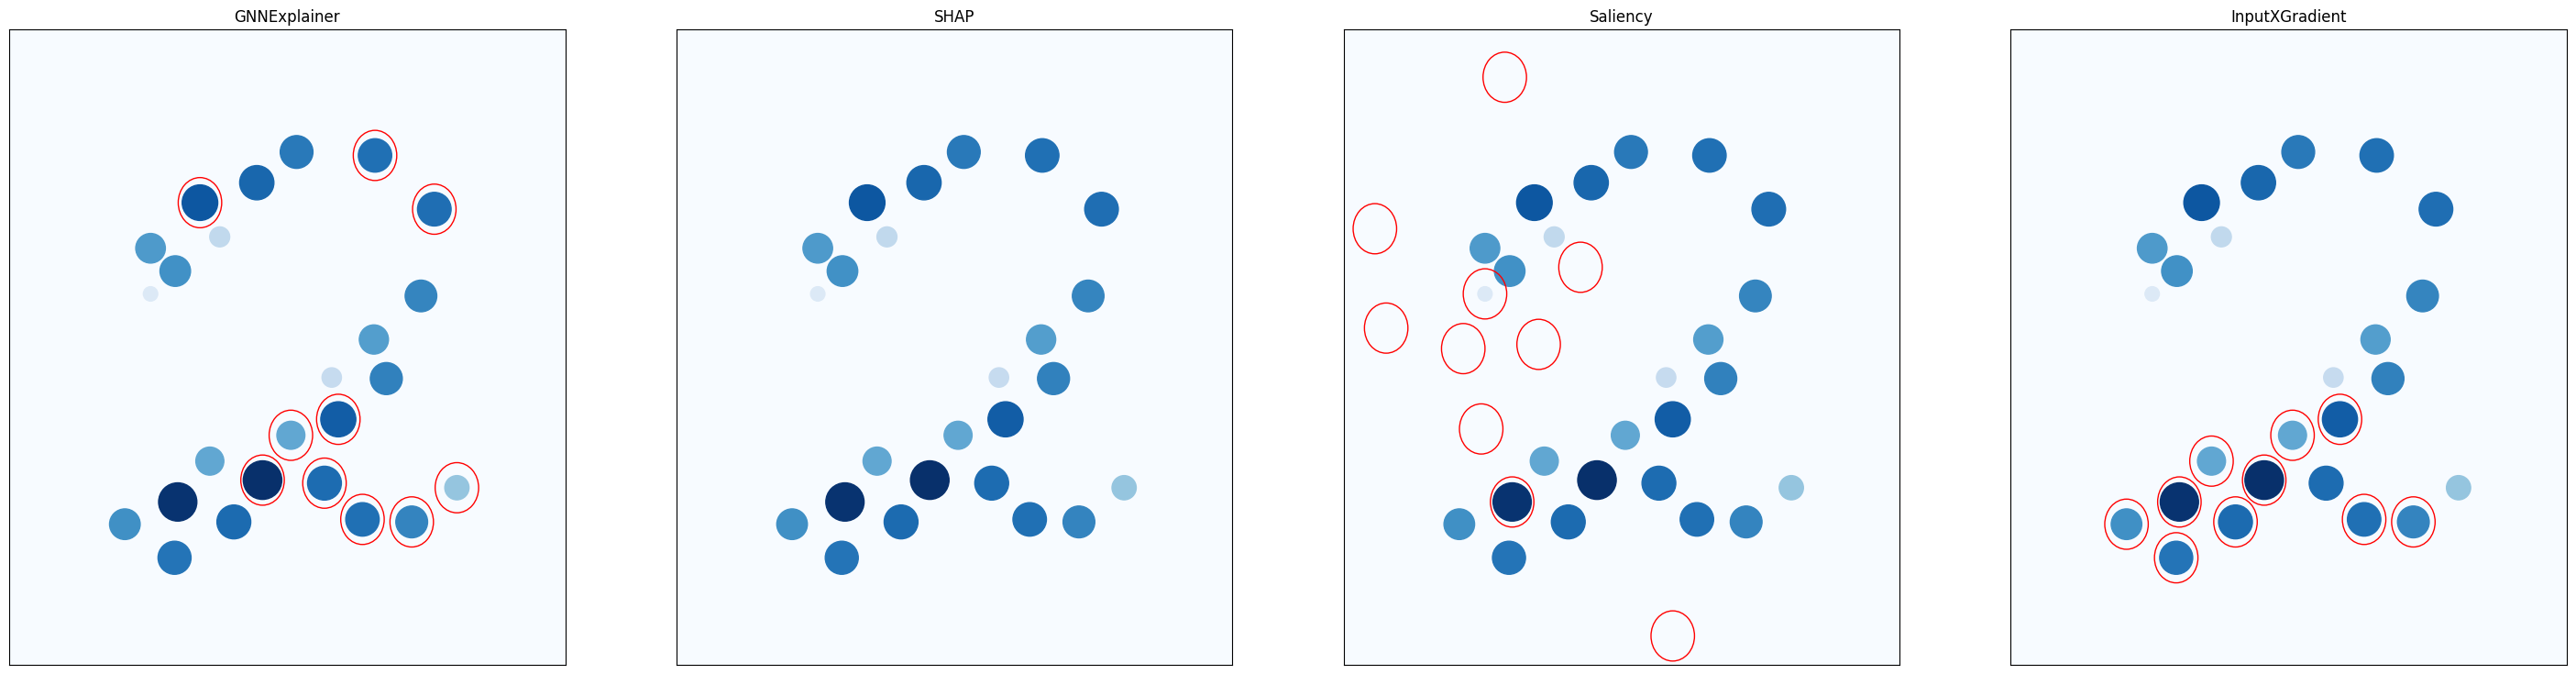

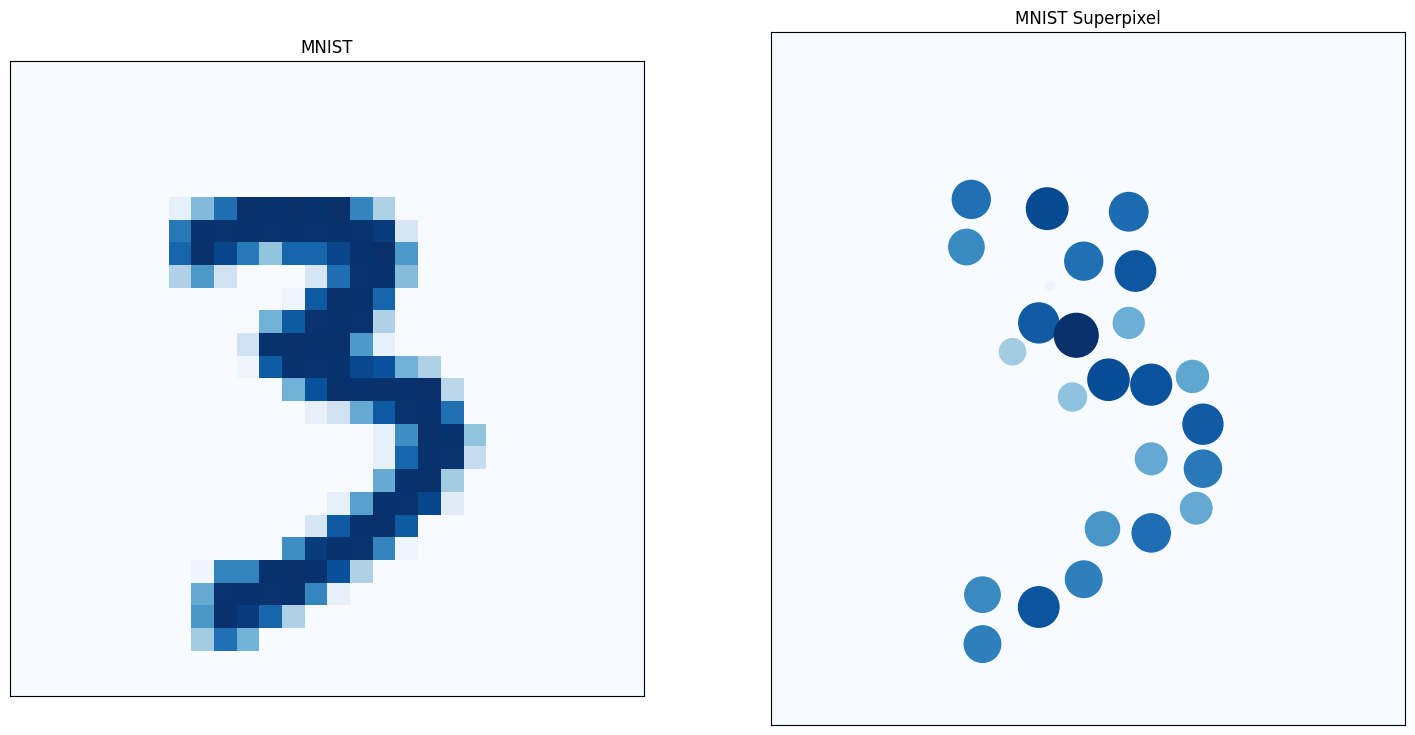

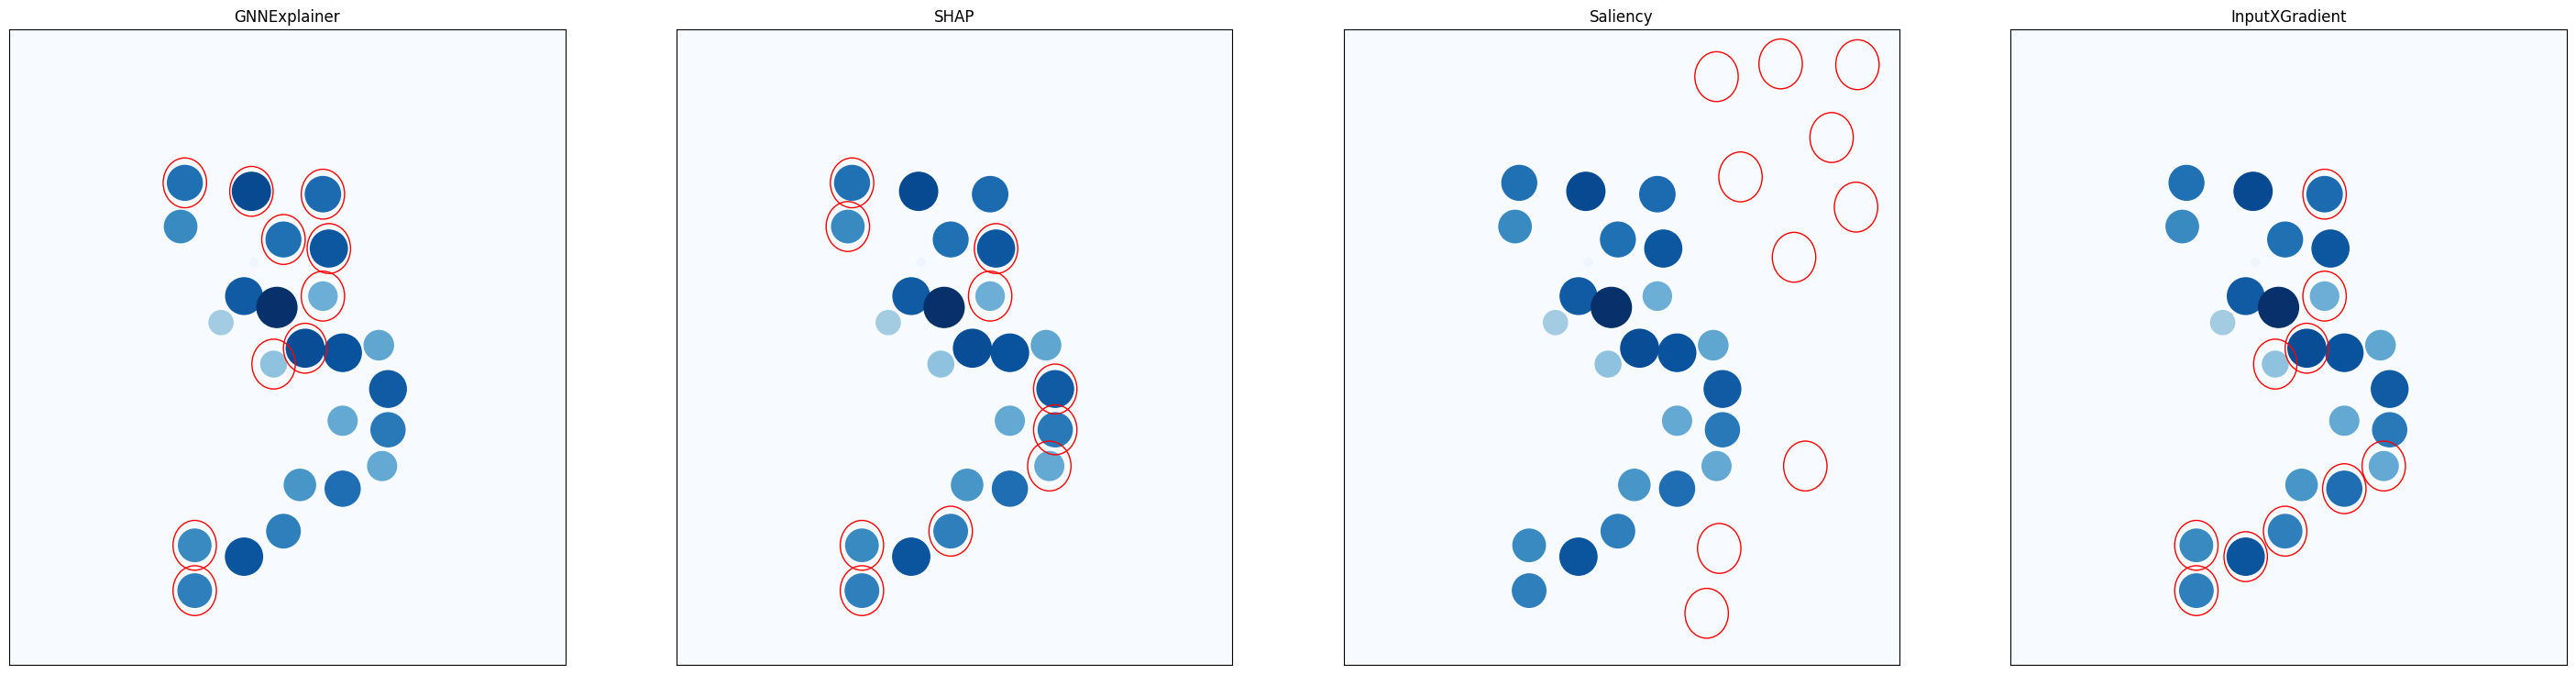

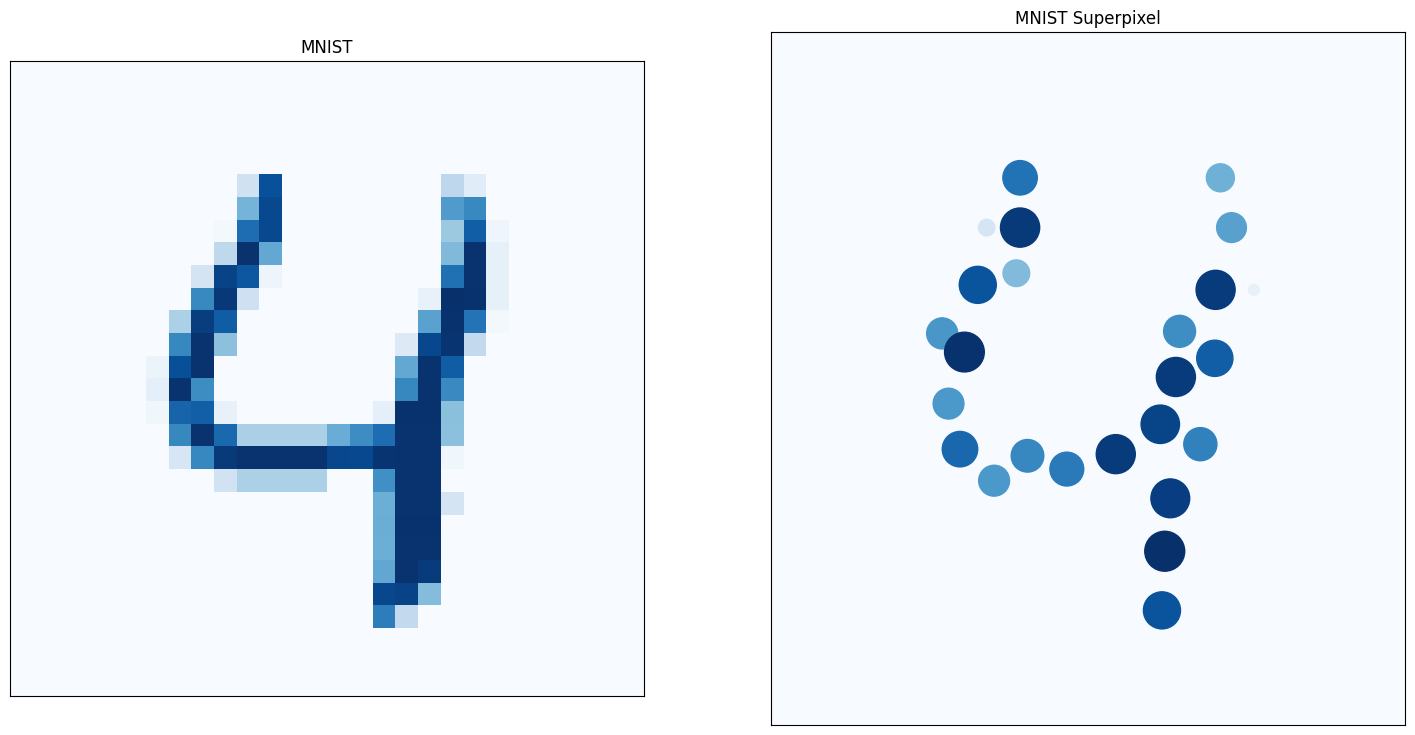

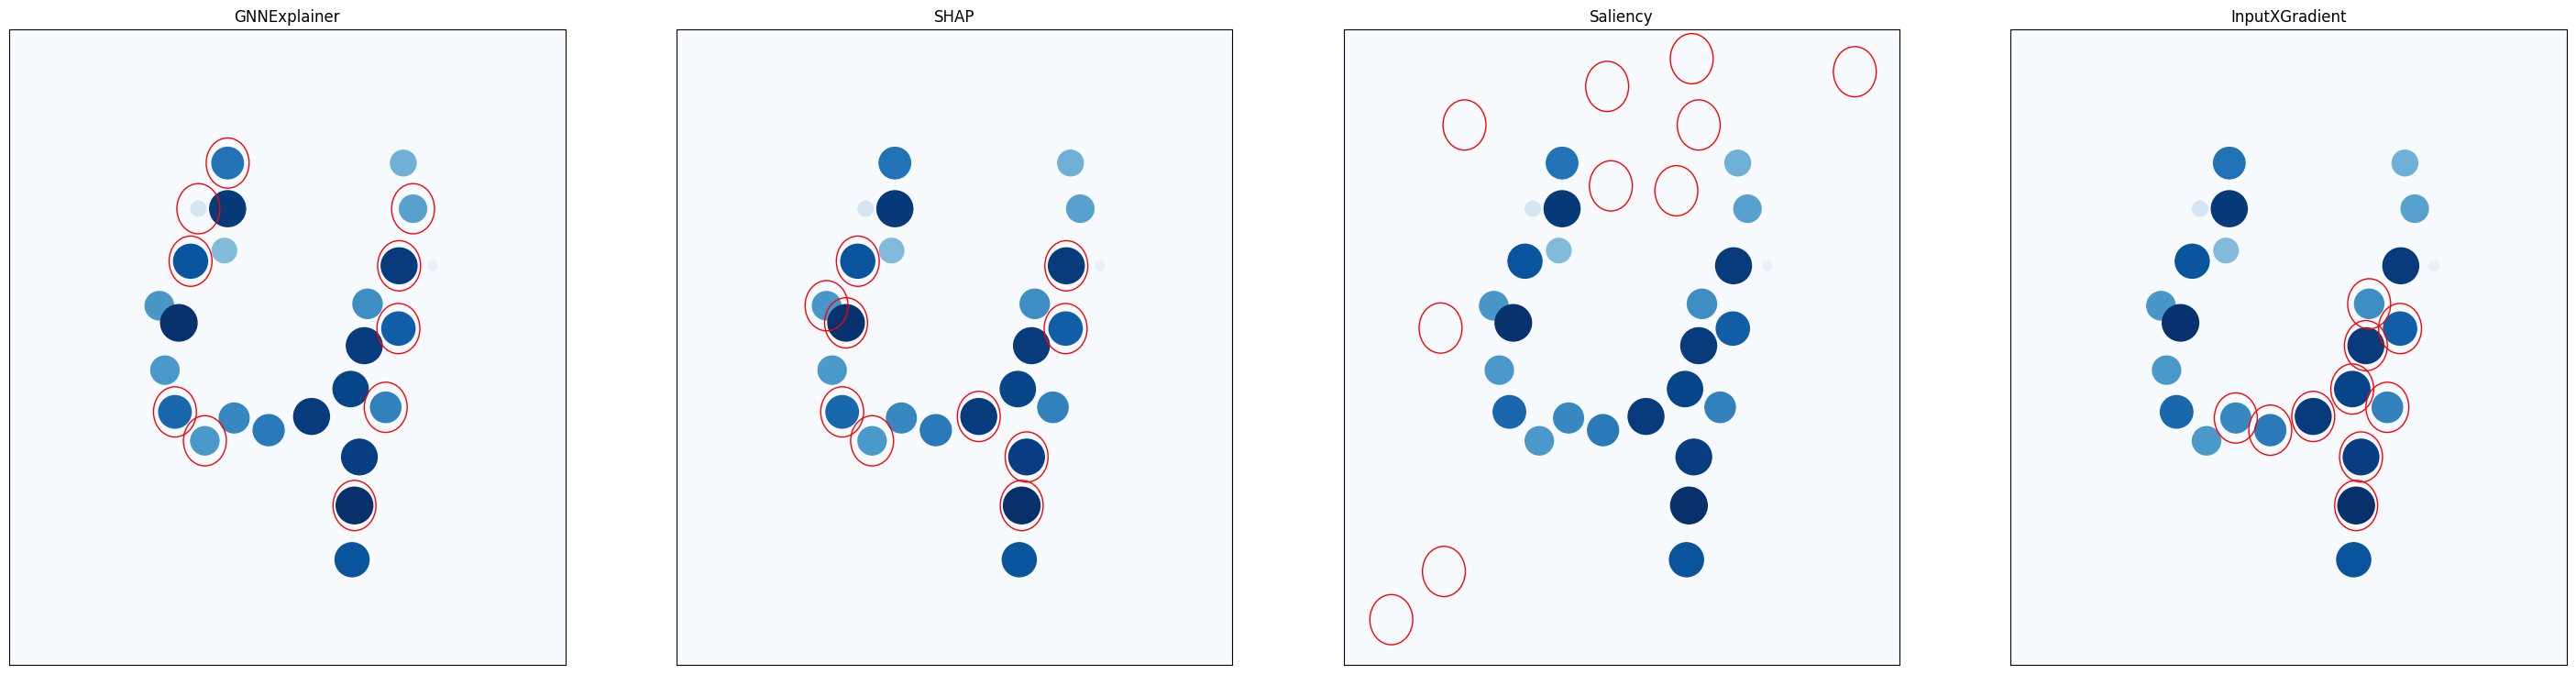

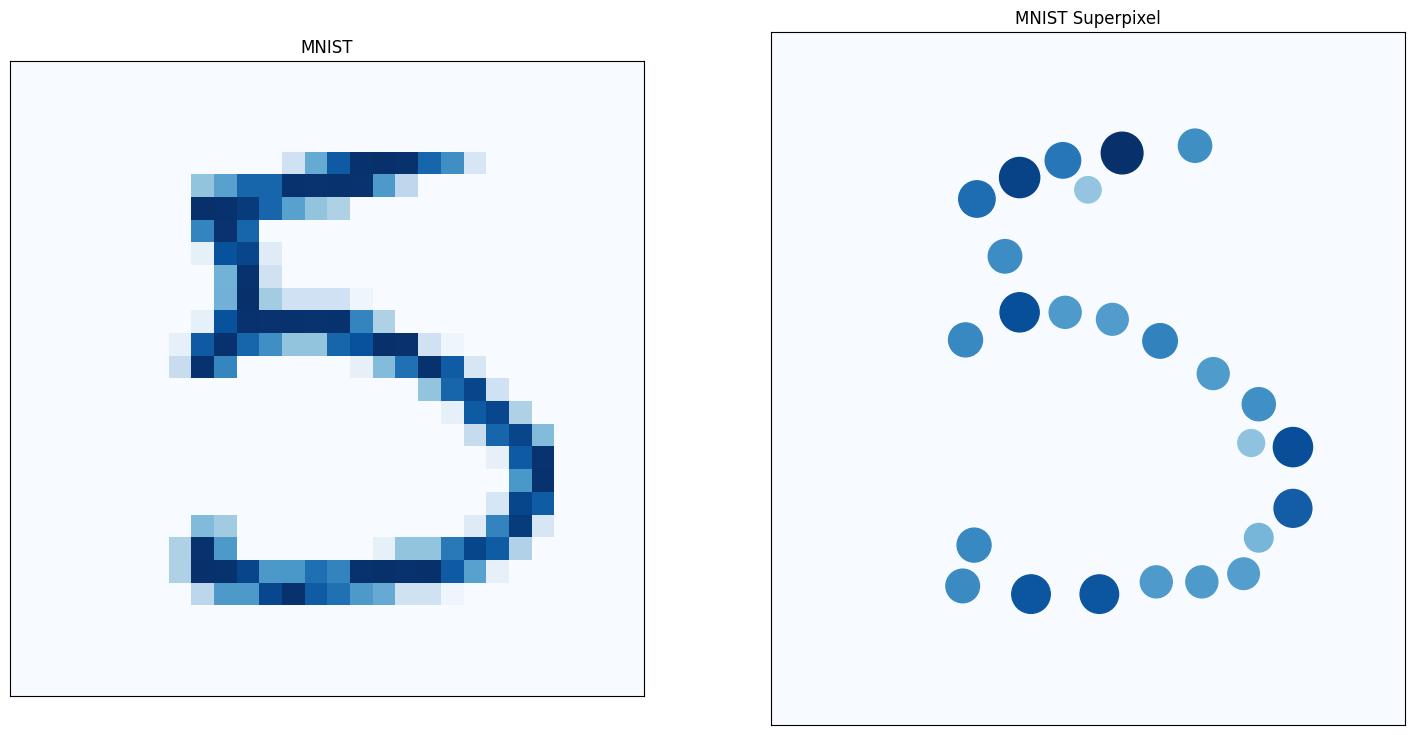

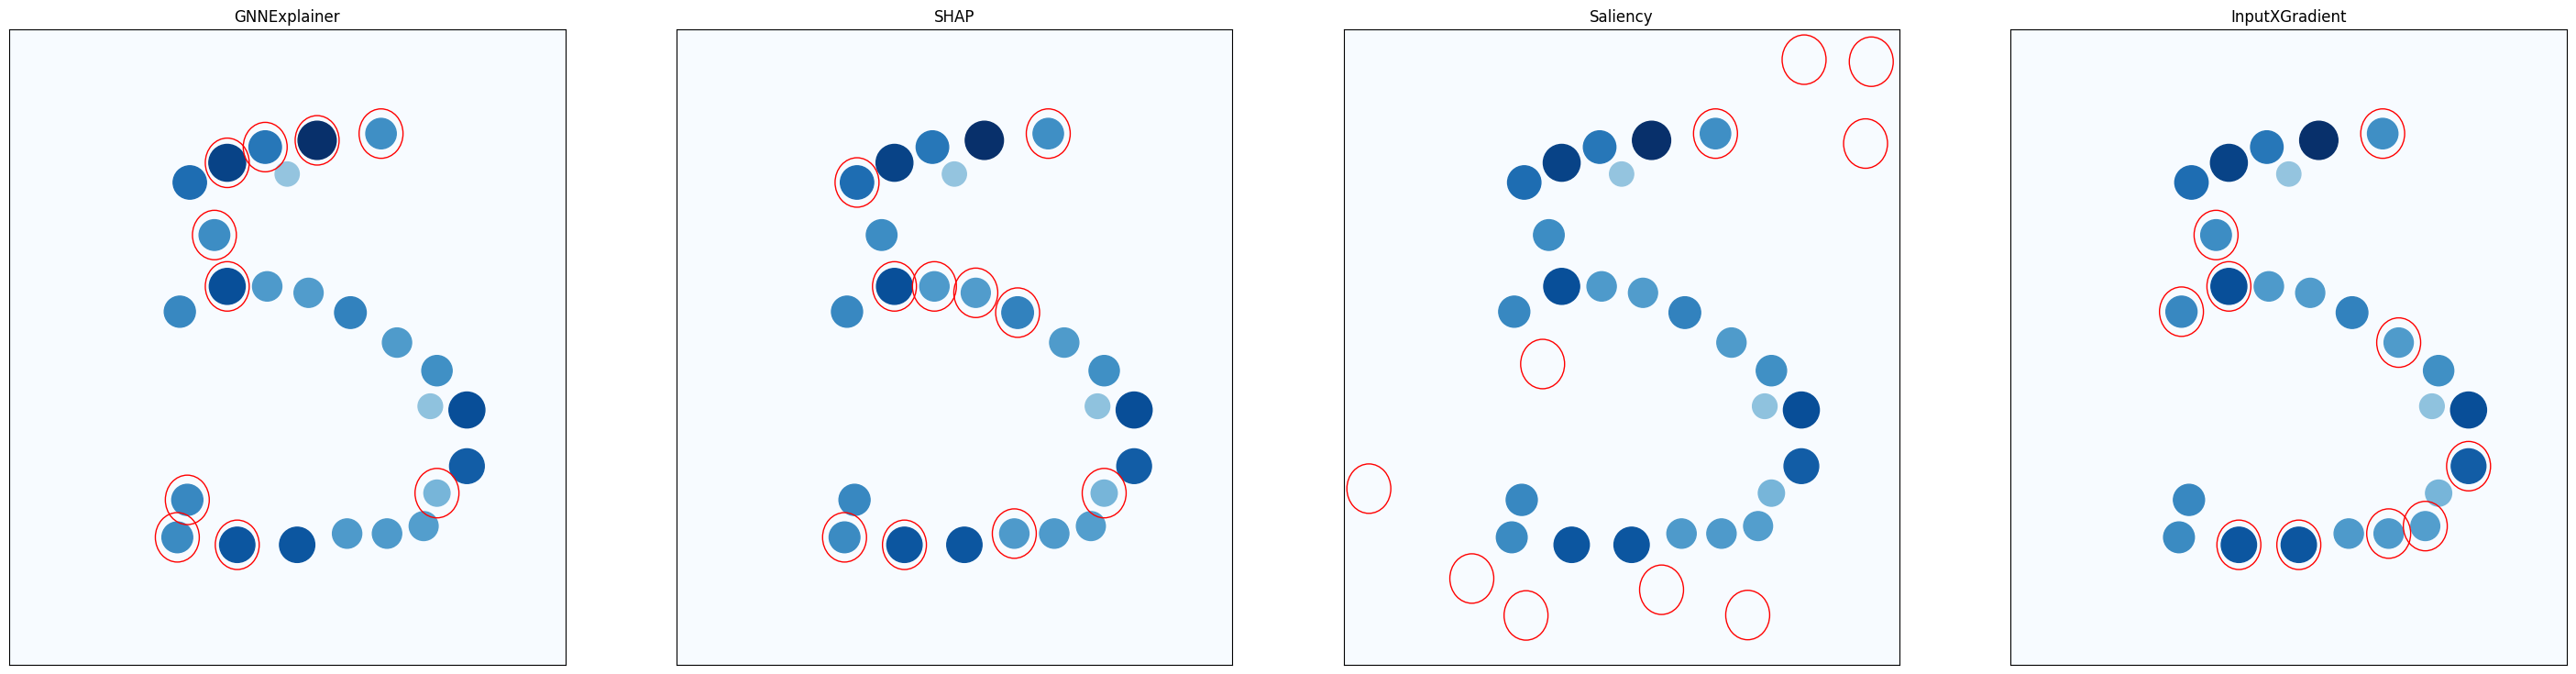

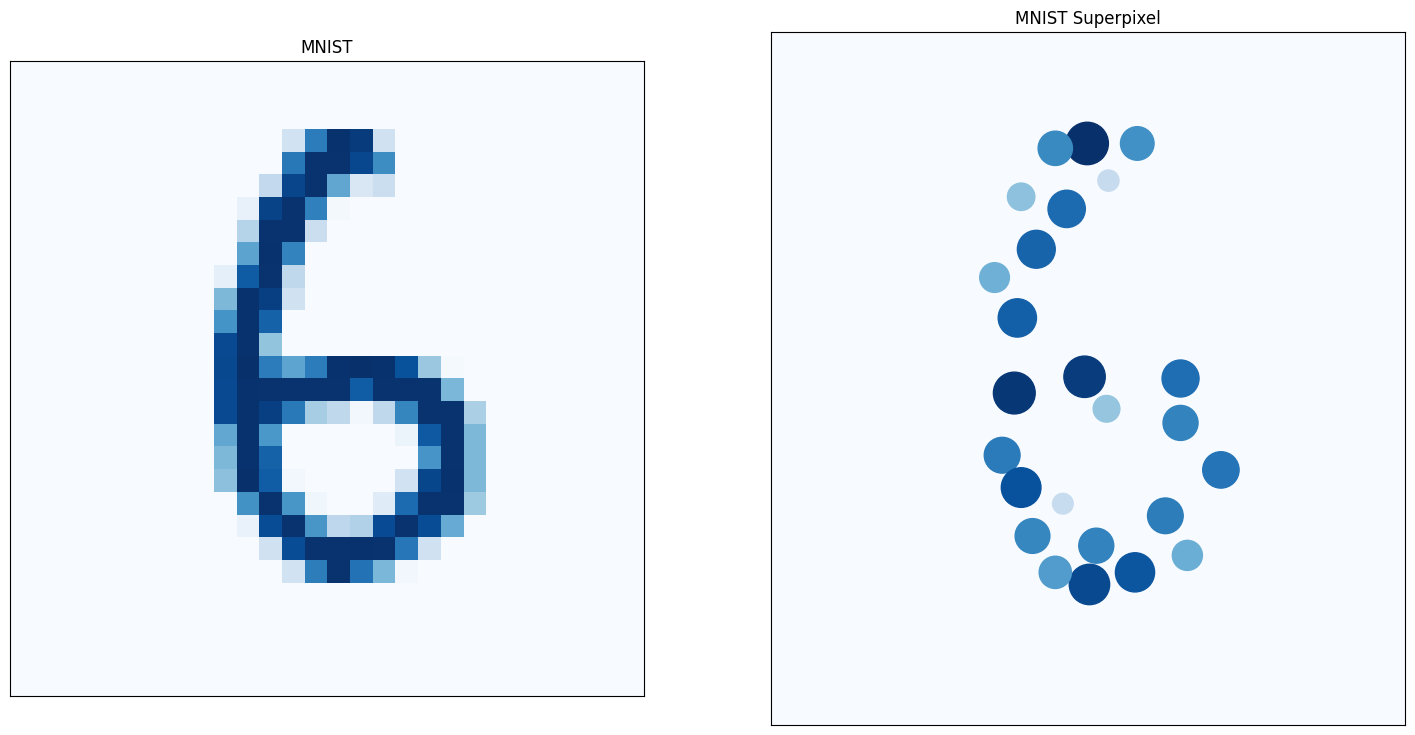

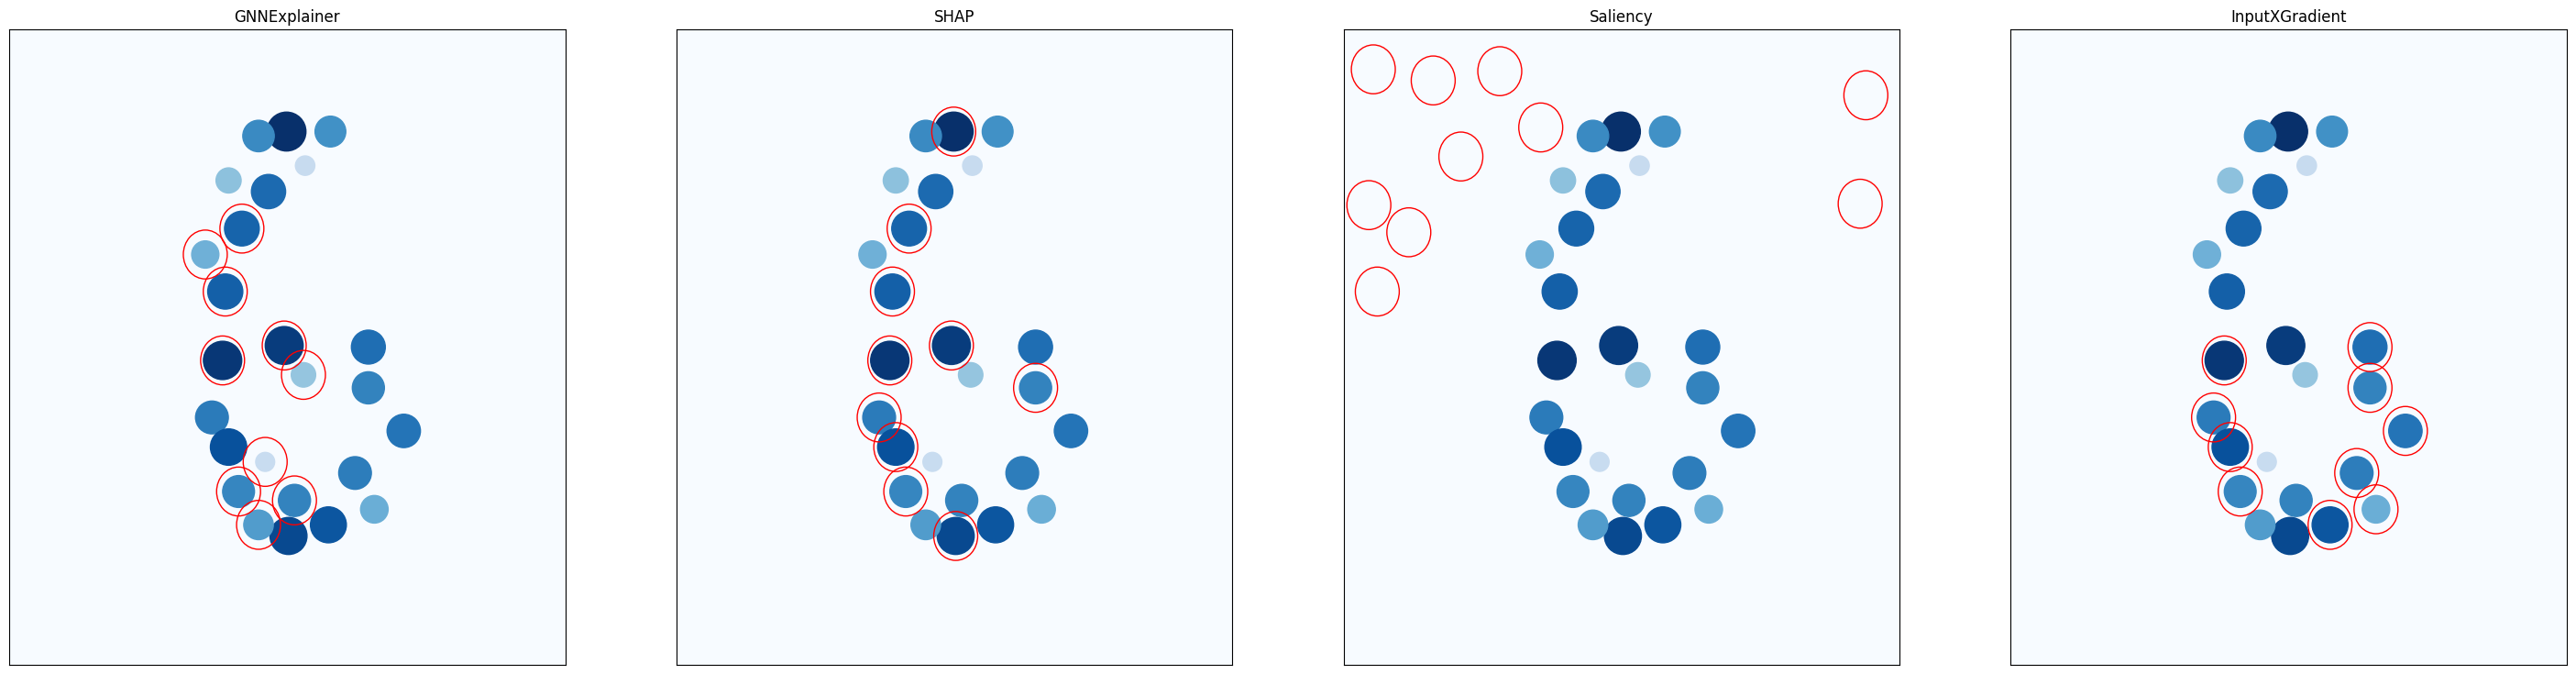

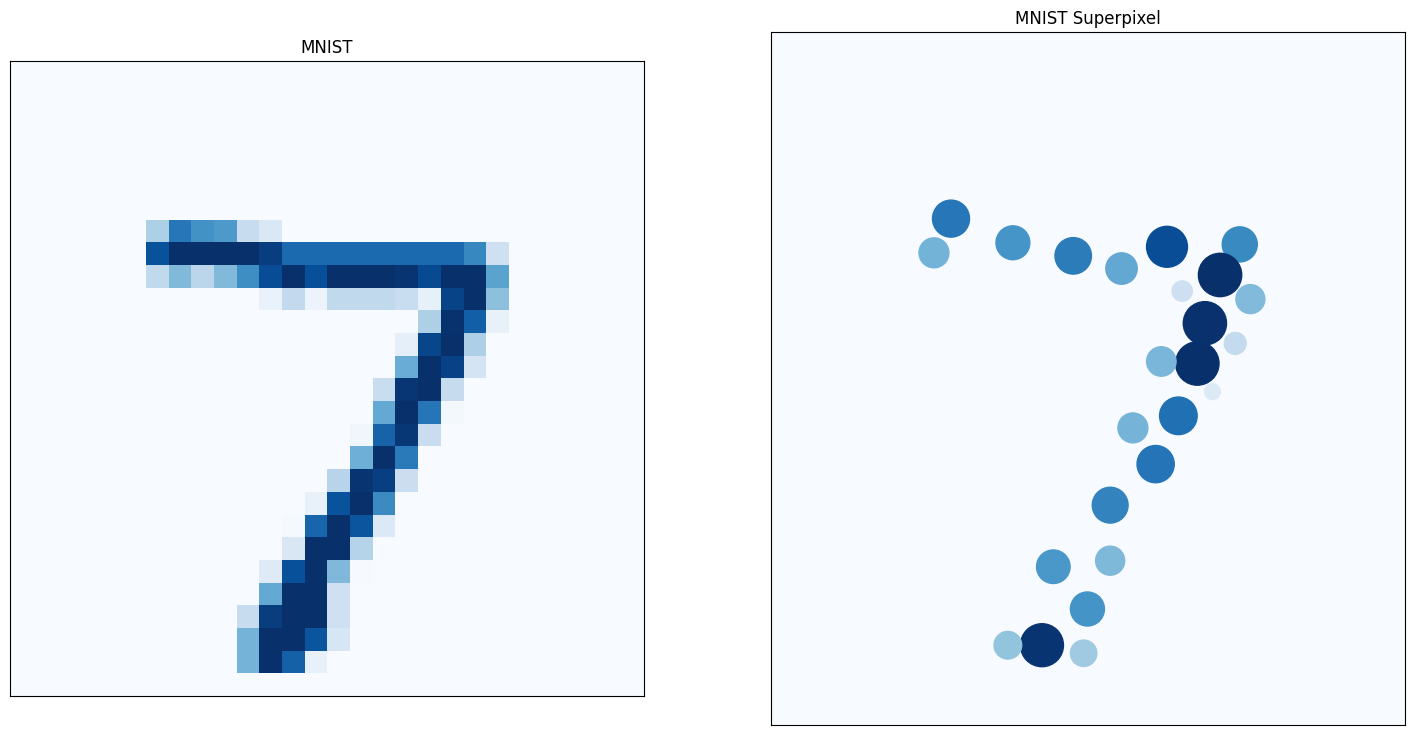

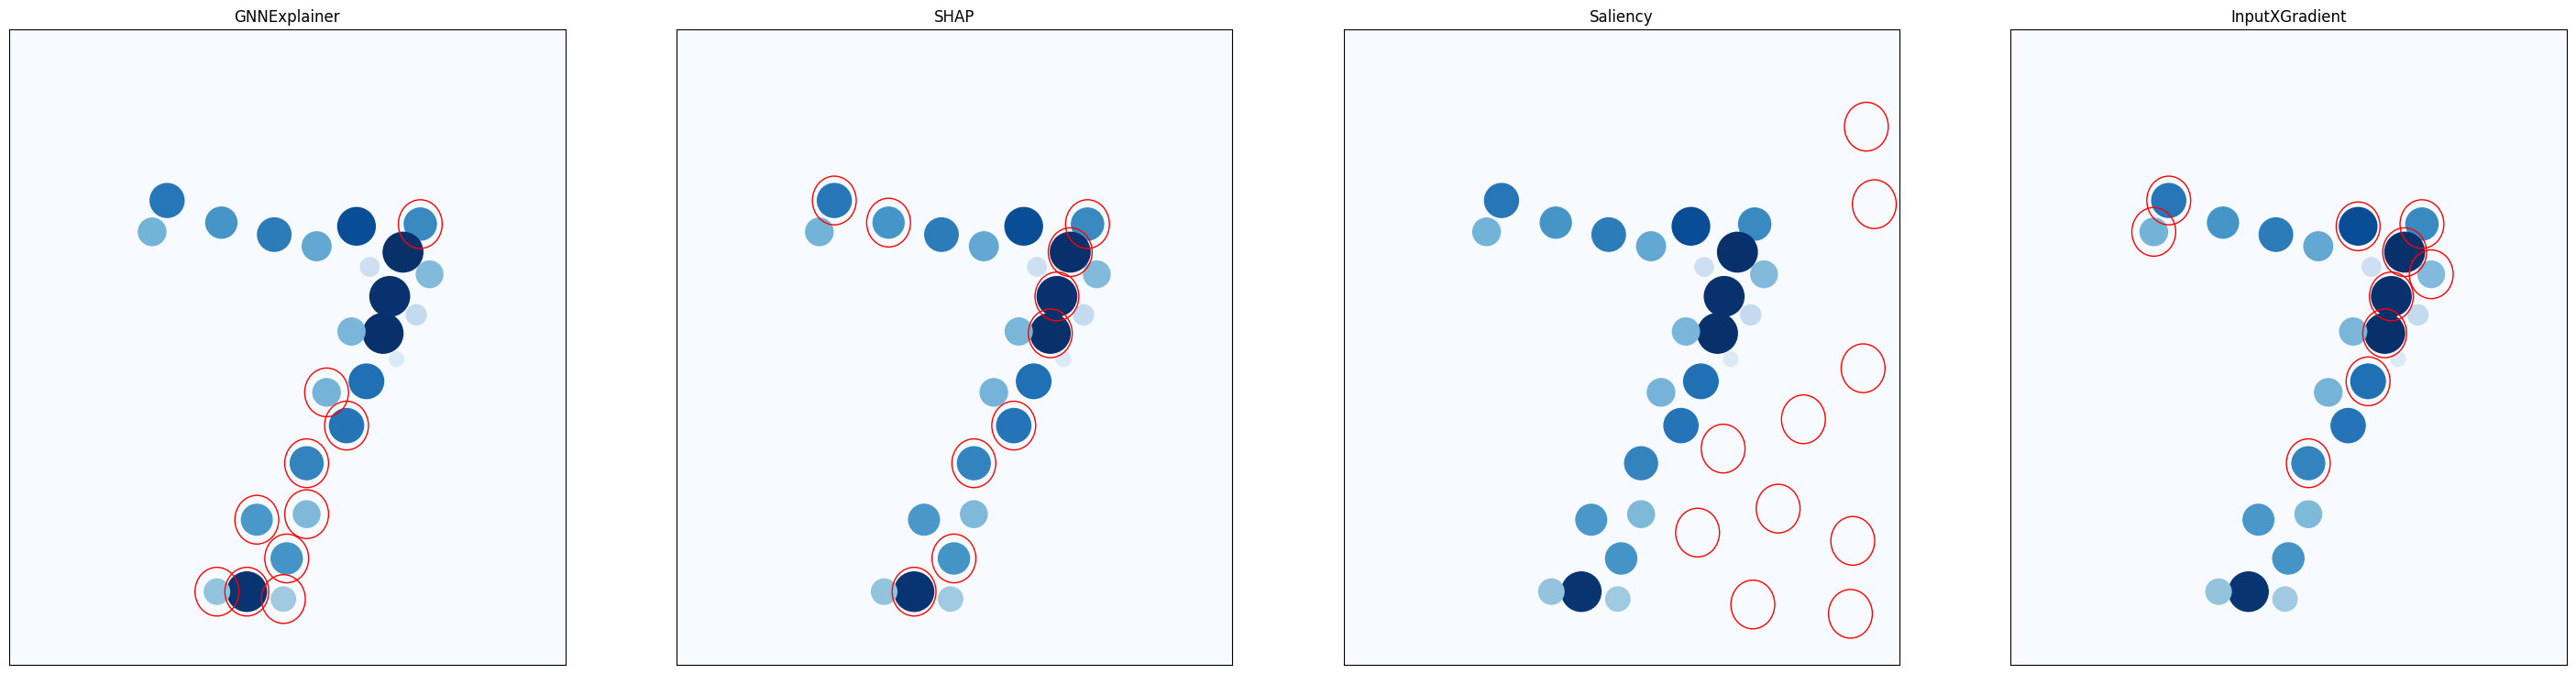

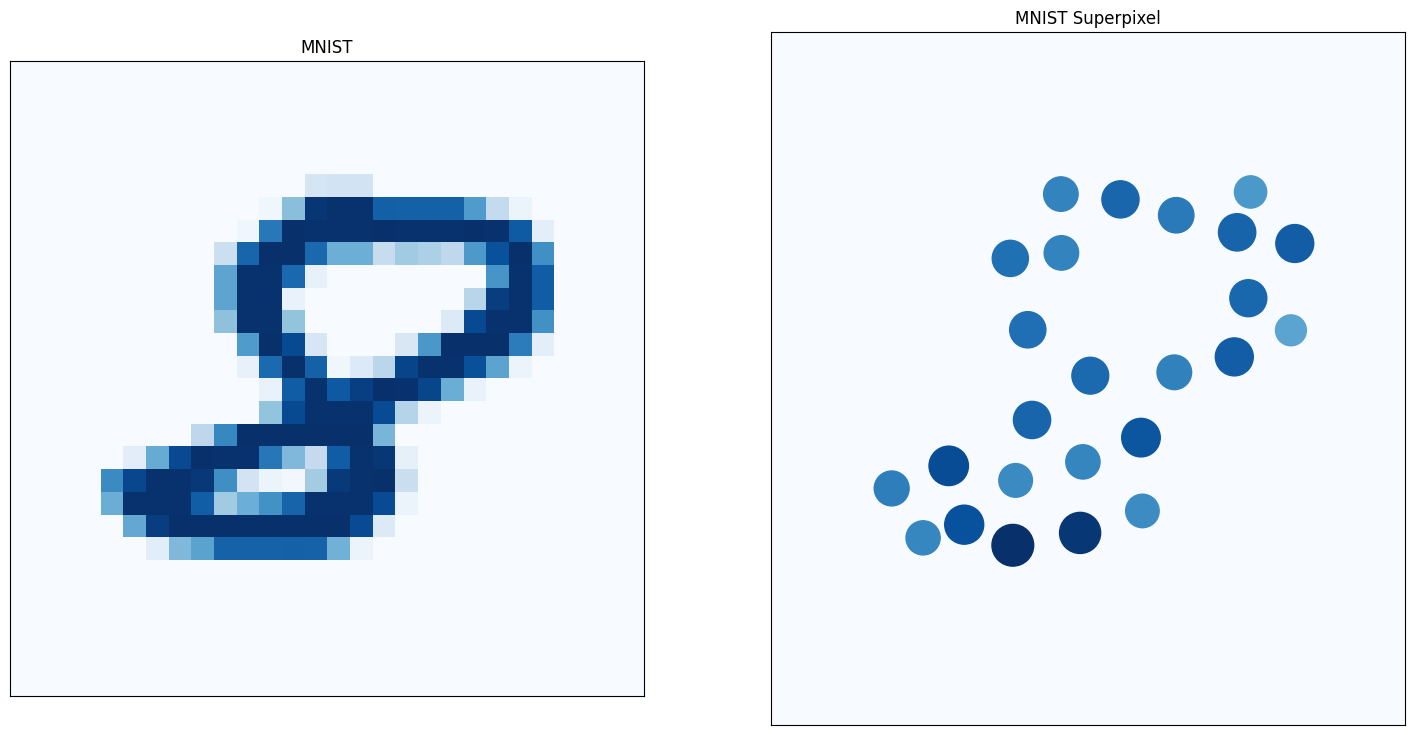

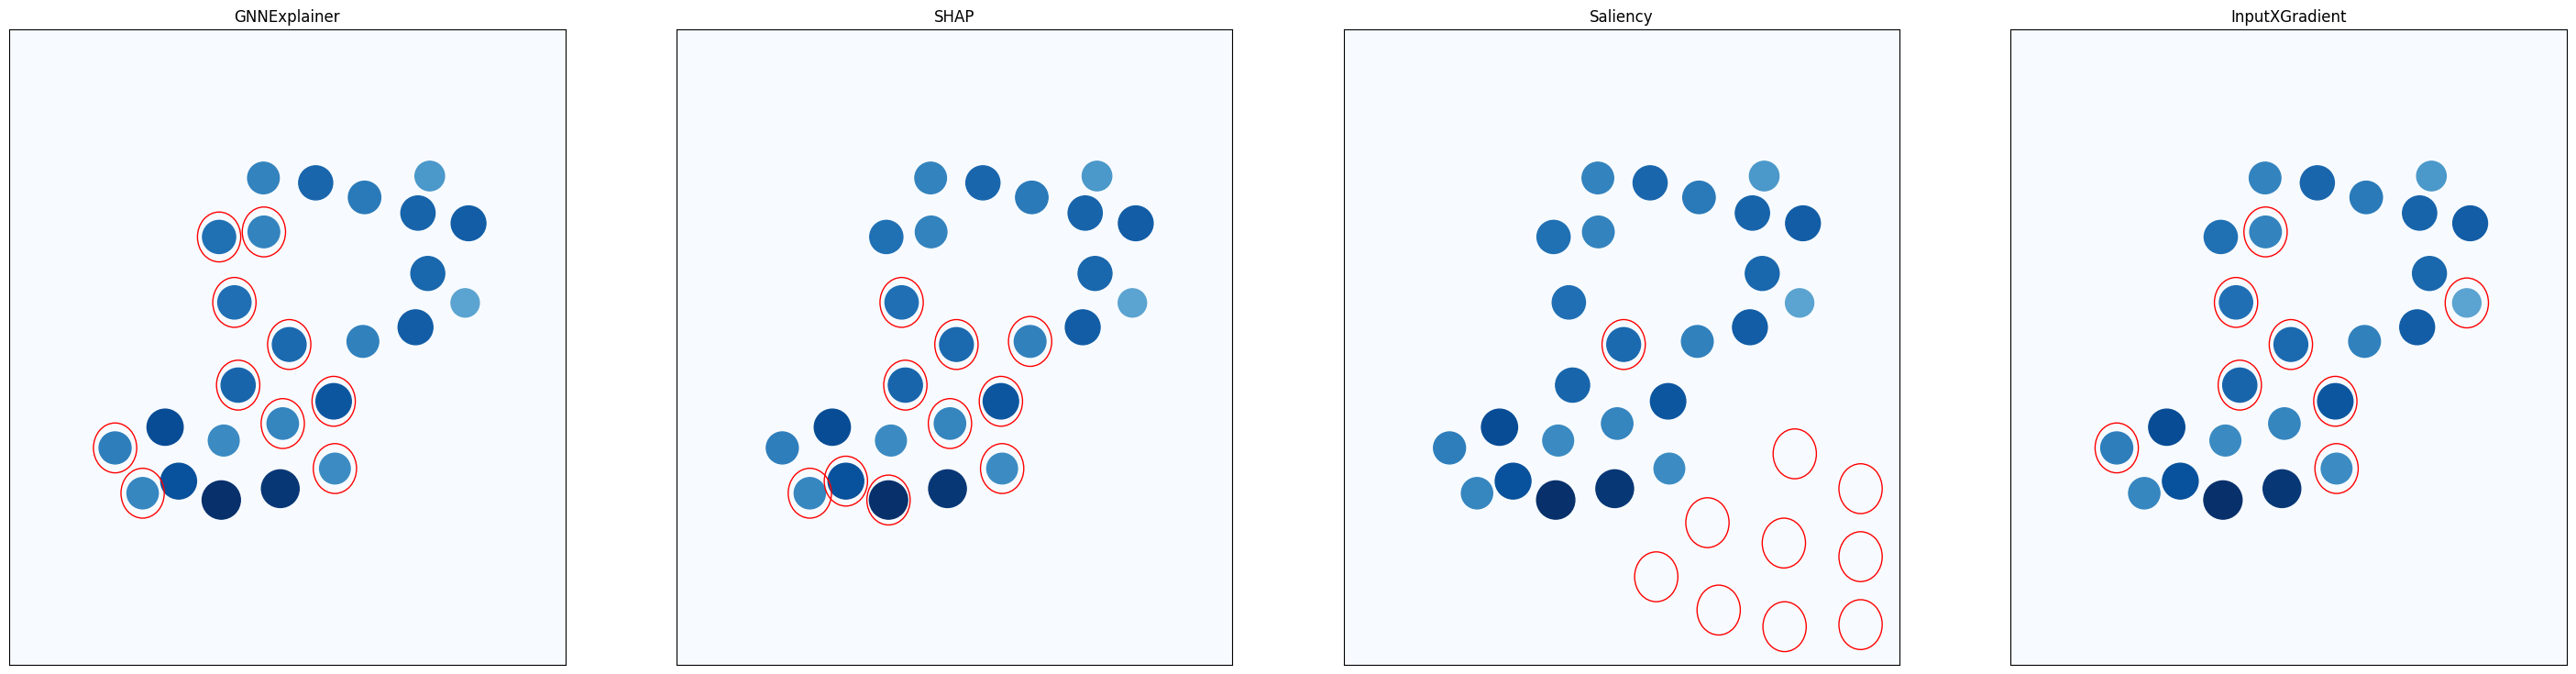

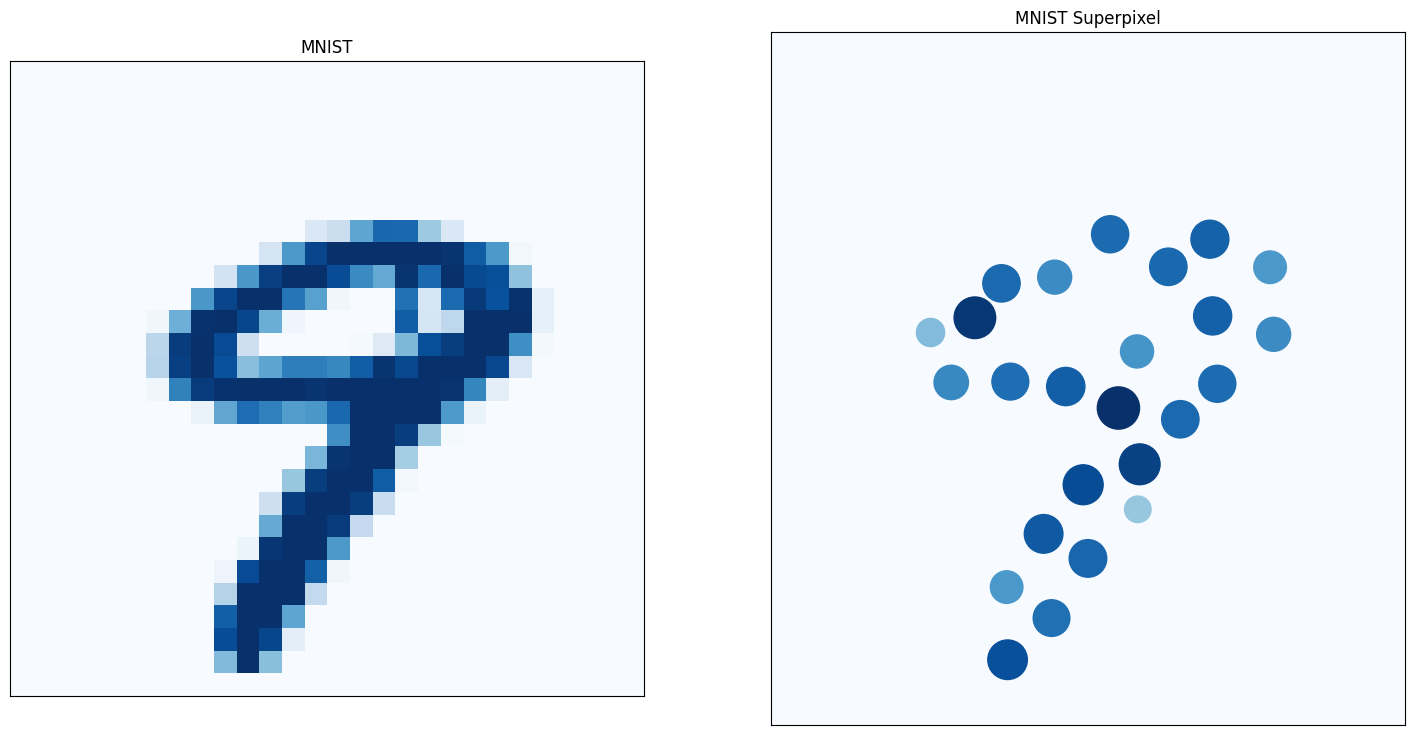

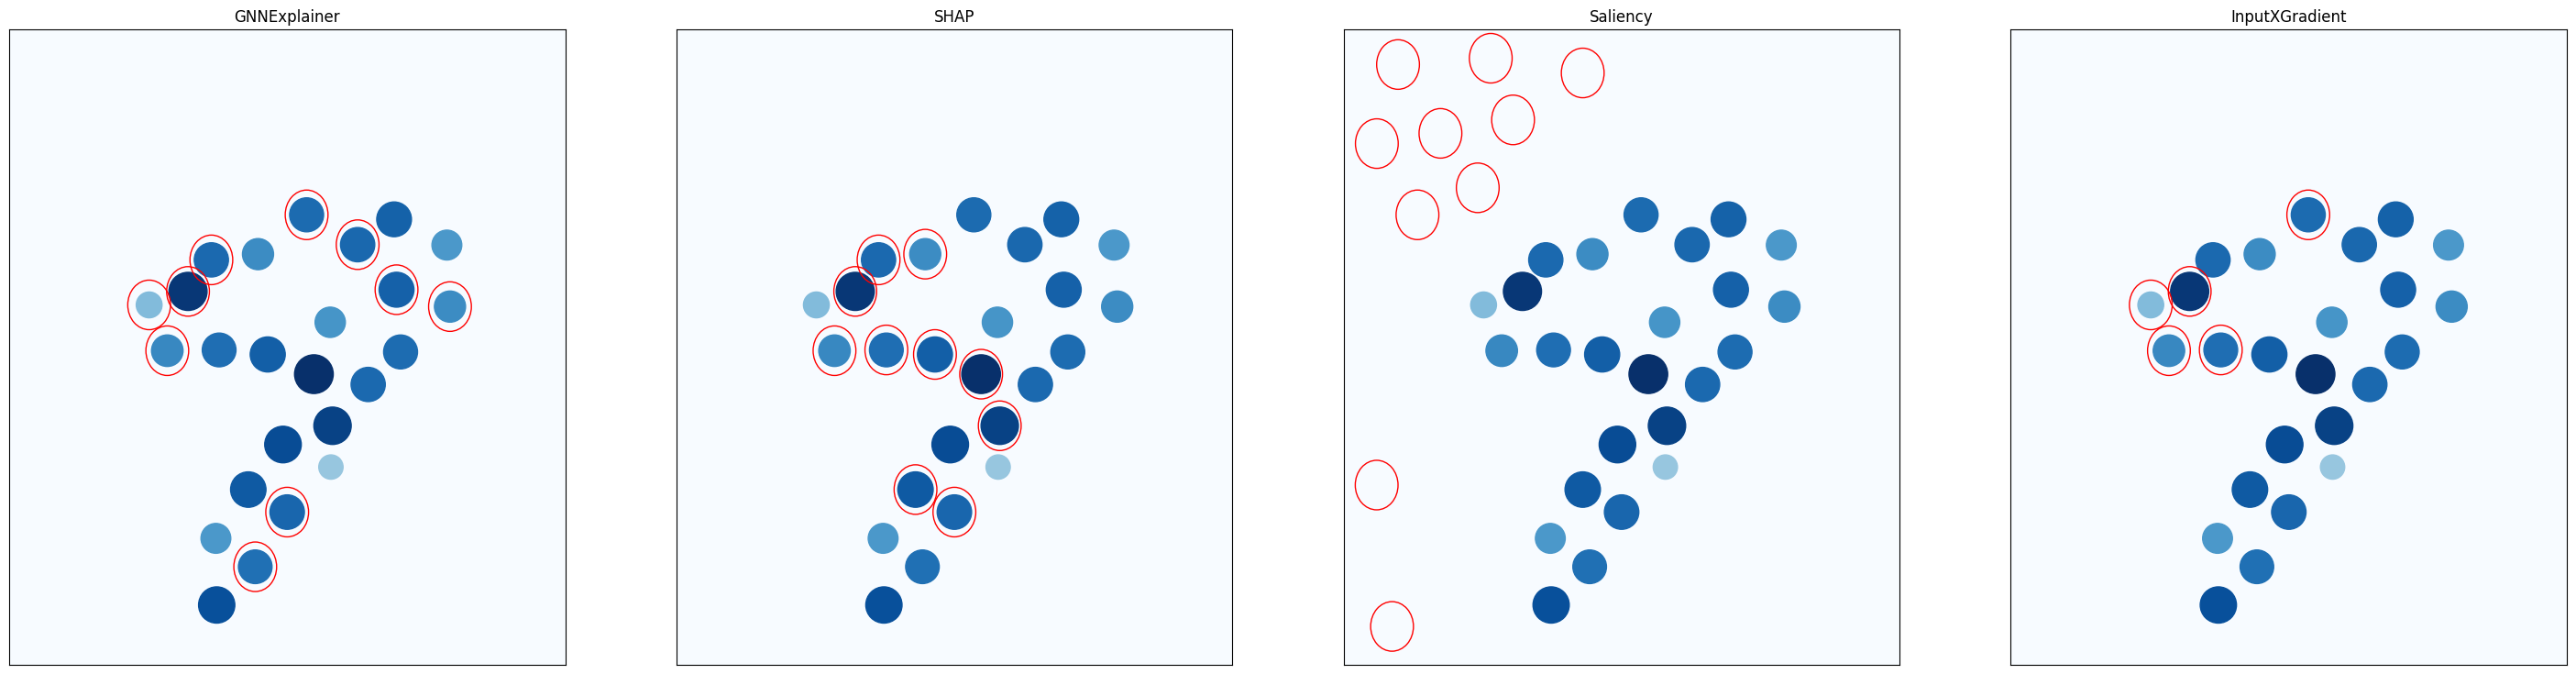

In [44]:
from torchvision.datasets import MNIST

indexes = [
    3,  # 0
    2,  # 1
    35, # 2
    30, # 3
    4,  # 4
    15, # 5
    21, # 6
    0,  # 7
    61, # 8
    9,  # 9
]
mnist_images = MNIST('./data/mnist', train=False, download=True)
numbers = test_dataset[indexes]
explanations = json.load(open('./MNISTSuperPixel_gcn_explanations.json', 'r'))

for i in range(len(indexes)):
    idx = indexes[i]
    img = mnist_images[idx][0]
    data = numbers[i]
    print(f'Class: {data.y.item()}, Prediction: {model(data.x, data.edge_index).argmax(dim=1).item()}')
    visualize(img, data, explanations[i * len(explainers):(i + 1) * len(explainers)], cmap=plt.cm.Blues)
